* To investigate the difference of flux, salt, and freshwater between two bathymetries.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools,rivertools)
import datetime, os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

In [2]:
transects = {'1':{'jst':55, 'ist':25,'jen':56,'ien':80},
            '2':{'jst':25, 'ist':25,'jen':26,'ien':75},
            '3':{'jst':25, 'ist':25,'jen':56,'ien':26},
            '4':{'jst':37, 'ist':72,'jen':45,'ien':73},
            '5':{'jst':120, 'ist':138,'jen':121,'ien':139},
            '6':{'jst':96,'ist':125,'jen':97,'ien':126},
            '7':{'jst':36,'ist':98,'jen':37,'ien':99},
            '8':{'jst':34,'ist': 90,'jen':37,'ien':91}}
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
grid2 = nc.Dataset('/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc')
X = grid6.variables['nav_lon'][380:510,240:397]
Y = grid6.variables['nav_lat'][380:510,240:397]
bathy = grid6.variables['Bathymetry'][380:510,240:397]
bathy2 = grid2.variables['Bathymetry'][380:510,240:397]

In [3]:
## mask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
umask = mesh.variables['umask'][0,:,380:510,240:397]
vmask = mesh.variables['vmask'][0,:,380:510,240:397]
e3u = mesh.variables['e3u'][0,:,380:510,240:397]
e3v = mesh.variables['e3v'][0,:,380:510,240:397]
e3t = mesh.variables['e3t'][0,:,380:510,240:397]
e2t = mesh.variables['e2t'][0,380:510,240:397]
e1t = mesh.variables['e1t'][0,380:510,240:397]
np_mask = np.abs(1-tmask) 

(48.95, 49.2)

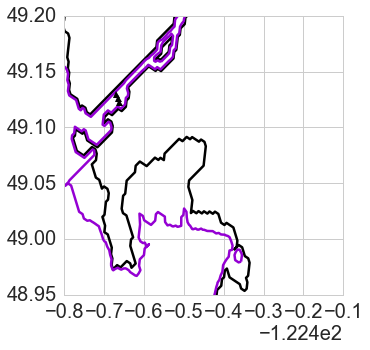

In [4]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
#ax.plot(X[55,25:80],Y[55,25:80],'r^')
#ax.plot(X[25,25:75],Y[25,25:75],'b^')
#ax.plot(X[25:56,25],Y[25:56,25],'g^')
#ax.plot(X[37:45,72],Y[37:45,72],'y^')
ax.plot(X[34:37,90],Y[34:37,90],'k^')
#ax.plot(X[120:121,138],Y[120:121,138],'k^')
#ax.annotate ('transect 1',(X[55,50],Y[55,50]), xycoords="data",color = 'r')
#ax.annotate ('transect 2',(X[25,50],Y[25,50]), xycoords="data",color = 'b')
#ax.annotate ('transect 3',(X[40,25],Y[40,25]), xycoords="data",color = 'g')
#ax.annotate ('transect 4',(X[25,70],Y[25,70]), xycoords="data",color = 'y')
ax.set_xlim([-123.2,-122.5])
ax.set_ylim([48.95,49.2])

In [5]:
## load salinity into a dict
paths = ['Oct2014nowind','Oct2014nowindBathy2_accurate']
base='/data/jieliu/MEOPAR/SurfaceCurrent/'
file_patternT = 'oct2014*_T.nc'
file_patternU = 'oct2014*_U.nc'
file_patternV = 'oct2014*_V.nc'
U = {}; V={}; S={};ssh = {}
for pa in paths:
    pathT = glob(os.path.join(base,pa, file_patternT))
    pathU = glob(os.path.join(base,pa, file_patternU))
    pathV = glob(os.path.join(base,pa, file_patternV))
    fU = nc.Dataset(pathU[0],'r');
    U[pa] = fU.variables['vozocrtx']
    fV = nc.Dataset(pathV[0],'r');
    V[pa] = fV.variables['vomecrty']
    depU = fU.variables['depthu']
    depV = fV.variables['depthv']
    fT = nc.Dataset(pathT[0],'r');
    S[pa] = fT.variables['vosaline']
    lon = fT.variables['nav_lon'] 
    lat = fT.variables['nav_lat']
    ssh[pa] = fT.variables['sossheig']
    time_counter = fT.variables['time_counter']
    depT = fT.variables['deptht']

In [6]:
def transport_calculate(S,U,V,ssh,lon,lat,depU,depV,tran,t_st,t_en,S0,fresh_flag = 'fresh',\
                                y0lim =6e5, y1lim = 6000):
    """Same as transport_calculate function, but focus on a continous time period rather 
    than a specific time, including fresh water flux 'fresh' flag,
    salt flux 'salt' flag, and total flux 'None' flag"""
    UU = {}; VV= {};SS={}
    jinds = np.arange(transects[tran]['jst'],transects[tran]['jen']+1)
    iinds = np.arange(transects[tran]['ist'],transects[tran]['ien']+1)
    for pa in paths:
        SS[pa] = np.zeros([time_counter.shape[0],depU.shape[0],jinds.shape[0],iinds.shape[0]])
        UU[pa] = np.zeros([time_counter.shape[0],depU.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        VV[pa] = np.zeros([time_counter.shape[0],depV.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        for t in np.arange(t_st,t_en+1):
            SS[pa][t] = S[pa][t,:,jinds,iinds]    
            mask=np_mask[:,jinds[0]:jinds[-1]+1,iinds[0]:iinds[-1]+1]
            SS[pa][t] = np.ma.masked_array(SS[pa][t],mask=mask) ## mask sal=0 by tmask 
                    
            if tran == '5' or tran =='7': ##single grid T cell
                u = np.add(U[pa][t,:,jinds[0],iinds][..., :-1], U[pa][t,:,jinds[0],iinds][..., 1:]) / 2
                VV[pa][t]=0
                UU[pa][t] = u.reshape(depU.shape[0],1,1)
            elif tran == '6': ## single grid T cell
                UU[pa][t] =0
                v =np.add(V[pa][t,:,jinds,iinds[0]][..., :-1], V[pa][t,:,jinds,iinds[0]][..., 1:]) / 2
                VV[pa][t] = v.reshape(depV.shape[0],1,1)
            else:
                UU[pa][t],VV[pa][t] = viz_tools.unstagger(U[pa][t,:,jinds,iinds],\
                                          V[pa][t,:,jinds,iinds])

    trans,trans_sur,trans_to= transport_time(SS,UU,VV,ssh,lon,lat,depU,depV,tran,t_st,t_en,\
                                                S0,fresh_flag = fresh_flag) ## get surface/total transport
        ## location
    return trans,trans_sur,trans_to

In [7]:
def transport_time(S,U,V,ssh,lon,lat,depU,depV,tran,t_st,t_en,S0,fresh_flag = 'fresh'):
    """This function was made to calculate total 
    transport/fresh water transport during a continuous 
    period, rather than the specific time 
    fresh_flag = 'fresh', fresh flux; 'salt',salt flux; 'None', total flux"""
    trans = {}; trans_surf = {}; trans_total ={}
    if tran =='3' or tran =='4' or tran =='5' or tran =='7' or tran=='8': ## cross-shelf transport
        for pa in paths:
            trans[pa] = np.zeros([time_counter.shape[0],depU.shape[0],np.arange(transects[tran]['jen']-transects[tran]['jst']).shape[0]])
            for t in np.arange(t_st,t_en+1):
                for z in np.arange(depU.shape[0]):
                    for j in np.arange(transects[tran]['jen']-transects[tran]['jst']):
                        d = e2t[j+transects[tran]['jst'],transects[tran]['ist']]
                        if fresh_flag == 'None':
                            ratio = 1
                        elif fresh_flag =='salt' or fresh_flag =='saltNoV':
                            ratio = S[pa][t][z,j,0]
                        elif fresh_flag =='fresh':
                            ratio = (S0 - S[pa][t][z,j,0])/S0
                        adj_ssh = 1+ssh[pa][t,j+transects[tran]['jst'],transects[tran]['ist']]\
                        /np.sum(e3t[:,j+transects[tran]['jst'],\
                        transects[tran]['ist']]*tmask[:,j+transects[tran]['jst'],transects[tran]['ist']])
                        if fresh_flag =='saltNoV':
                            trans[pa][t,z,j] = d*e3t[z,j+transects[tran]['jst'],transects[tran]['ist']]*adj_ssh*ratio
                        else:
                            trans[pa][t,z,j] = U[pa][t,z,j,0]*d*e3t[z,j+transects[tran]['jst'],transects[tran]['ist']]*adj_ssh*ratio
    else: ## along-shore transport
        for pa in paths:
            trans[pa]= np.zeros([time_counter.shape[0],depV.shape[0],np.arange(transects[tran]['ien']-transects[tran]['ist']).shape[0]]);
            for t in np.arange(t_st,t_en+1):
                for z in np.arange(depV.shape[0]):
                    for i in np.arange(transects[tran]['ien']-transects[tran]['ist']):
                        d = e1t[transects[tran]['jst'],i+transects[tran]['ist']]
                        if fresh_flag == 'None':
                            ratio = 1
                        elif fresh_flag =='salt' or fresh_flag =='saltNoV':
                            ratio = S[pa][t][z,0,i]
                        elif fresh_flag =='fresh':
                            ratio = (S0 - S[pa][t][z,0,i])/S0

                        adj_ssh = 1+ssh[pa][t,transects[tran]['jst'],i+transects[tran]['ist']]\
                        /np.sum(e3t[:,transects[tran]['jst'],i+transects[tran]['ist']]*tmask[:,transects[tran]['jst'],i+transects[tran]['ist']])
                        if fresh_flag =='saltNoV':
                            trans[pa][t,z,i] = d*e3t[z,transects[tran]['jst'],i+transects[tran]['ist']]*adj_ssh*ratio ## shape of [40,54]
                        else:
                            trans[pa][t,z,i] = V[pa][t,z,0,i]*d*e3t[z,transects[tran]['jst'],i+transects[tran]['ist']]*adj_ssh*ratio ## shape of [40,54]
    ## surface and total transport in the dict
    for pa in paths:
        trans_surf[pa] = np.nansum(trans[pa][t_st:t_en+1,0,:],axis = 1)
        trans_total[pa] = np.nansum(np.nansum(trans[pa][t_st:t_en+1],axis = 1),axis = 1)
 
    return trans, trans_surf,trans_total

In [8]:
def plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,S0,data_start,fresh_flag = 'fresh'):
    """This function is the same with plot_series_transport, except 
    that this is not integral over several days, but only for 
    daily case."""
    trans,trans_surf,trans_to = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,\
                                                                 S0,fresh_flag = fresh_flag)
    inte_trans = {}; types = ['Oct2014nowind','Oct2014nowindBathy2_accurate']
    for ty in types:
        inte_trans[ty] = np.zeros((ten+1)/24)
    for i in np.arange(tst,ten+1,24):
        for ty in types:
            inte_trans[ty][i/24] = np.sum(trans_to[ty][i:i+24])*3600## intergral individual daily
    fig, axs = plt.subplots(2,1,figsize = (20,9))
    ax = axs[0] ## ssh
    for ty in types:
        ax.plot(ssh[ty][tst:ten+1,86,89],label = ty)
    ax.set_ylabel('ssh at PA [m]')
    ax.set_xlabel('hour')
    ax = axs[1] ## total volumn flux,salt flux and freshwater flux for selected run case and obs
    e1t, e2t = rivertools.get_bathy_cell_size(grid='/ocean/jieliu/research/meopar/nemo-forcing/grid/coordinates_seagrid_SalishSea.nc')
    real_flows = np.zeros((ten+1)/24);
    real_flows_bathy2 = np.zeros((ten+1)/24);
    data_path = '/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d'
    data_path_bathy2 = '/data/jieliu/MEOPAR/river-treatment/RFraserCElse_y2014m10d'

    string = 1
    for t in np.arange(tst/24,(ten+1)/24): ## default tst -0, from start
        if string <10:
            real = nc.Dataset(data_path+str(data_start)+str(string)+'.nc')
            real_bathy2 = nc.Dataset(data_path_bathy2+str(data_start)+str(string)+'.nc')
        elif string >=10:
            real = nc.Dataset(data_path+str(string)+'.nc')
            real_bathy2 = nc.Dataset(data_path_bathy2+str(string)+'.nc')
        print(data_path+str(data_start)+str(string)+'.nc')
        flow = real.variables['rorunoff'][0,500,395]
        real_flows[t] = -flow*e1t[0,500,395]*e2t[0,500,395]*24*3600/1000
        flow_bathy2 = real_bathy2.variables['rorunoff'][0,414,334]
        real_flows_bathy2[t] = -flow_bathy2*3*e1t[0,414,334]*e2t[0,414,334]*24*3600/1000
        string = string+1
    for ty in types:
        ax.plot(inte_trans[ty],'.',label = ty,markersize = 10)
        ax.set_ylabel('Flux $m^3$')    
        ax.set_xlim([(tst-24)/24,(ten+1)/24])
    ax.plot(real_flows,'*',label = 'real',markersize = 10)
    ax.plot(real_flows_bathy2,'^',label = 'real bathy2',markersize = 10)
    ax.legend(loc = 'best')
    ax.set_xlabel('Day')

In [9]:
def plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,S0,fresh_flag = 'fresh'):
    """Plot the transport time series in hourly results"""
    trans,trans_surf,trans_to = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,\
                                                                 S0,fresh_flag = fresh_flag)
    inte_trans = {}; types = ['Oct2014nowind','Oct2014nowindBathy2_accurate']
    fig, axs = plt.subplots(2,1,figsize = (20,9))
    ax = axs[0] ## ssh
    for ty in types:
        ax.plot(ssh[ty][tst:ten+1,86,89],label = ty)
    ax.set_ylabel('ssh at PA [m]')
    ax.set_xlabel('hour')
    ax = axs[1] ## total volumn flux,salt flux and freshwater flux for selected run case and obs
    for ty in types:
        ax.plot(trans_to[ty],'-',marker = '.',label = ty,markersize = 10)
        if fresh_flag =='saltNoV':
            ax.set_ylabel('Salinity integral $m^2$')
        else:
            ax.set_ylabel('Flux $m^3/s$')    
    ax.legend(loc = 'best')
    ax.set_xlabel('hour')

/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d01.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d02.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d03.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d04.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d05.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d06.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d07.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d08.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d09.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d010.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d011.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d012.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d013.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d014.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014

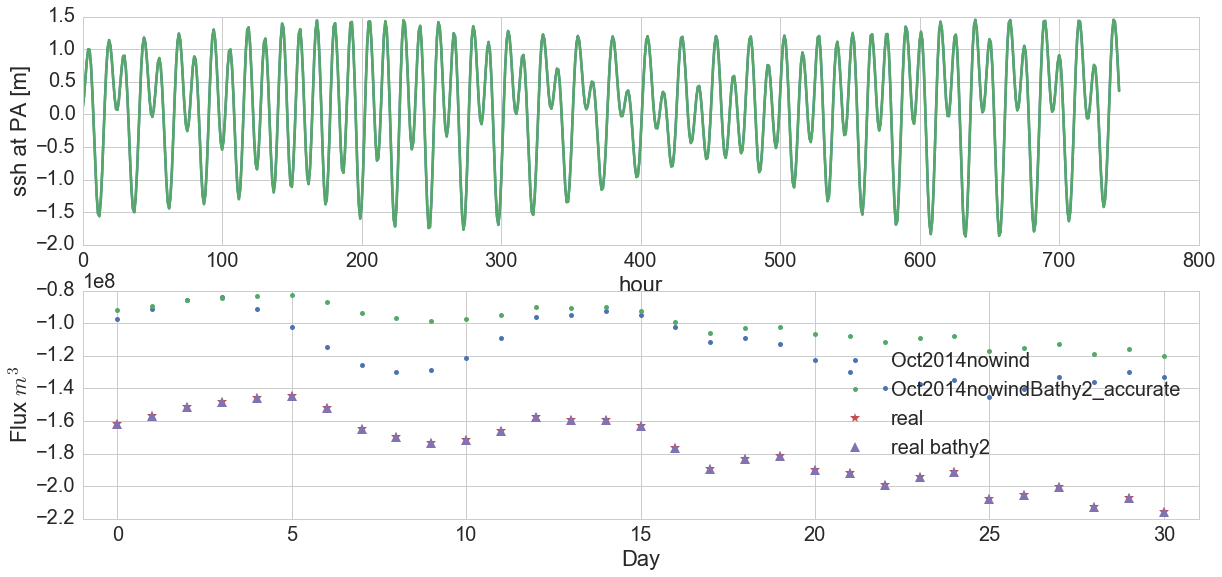

In [10]:
## Deas Island channel transect
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'8',0,743,30,0,fresh_flag='None')

/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d01.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d02.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d03.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d04.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d05.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d06.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d07.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d08.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d09.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d010.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d011.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d012.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d013.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d014.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014

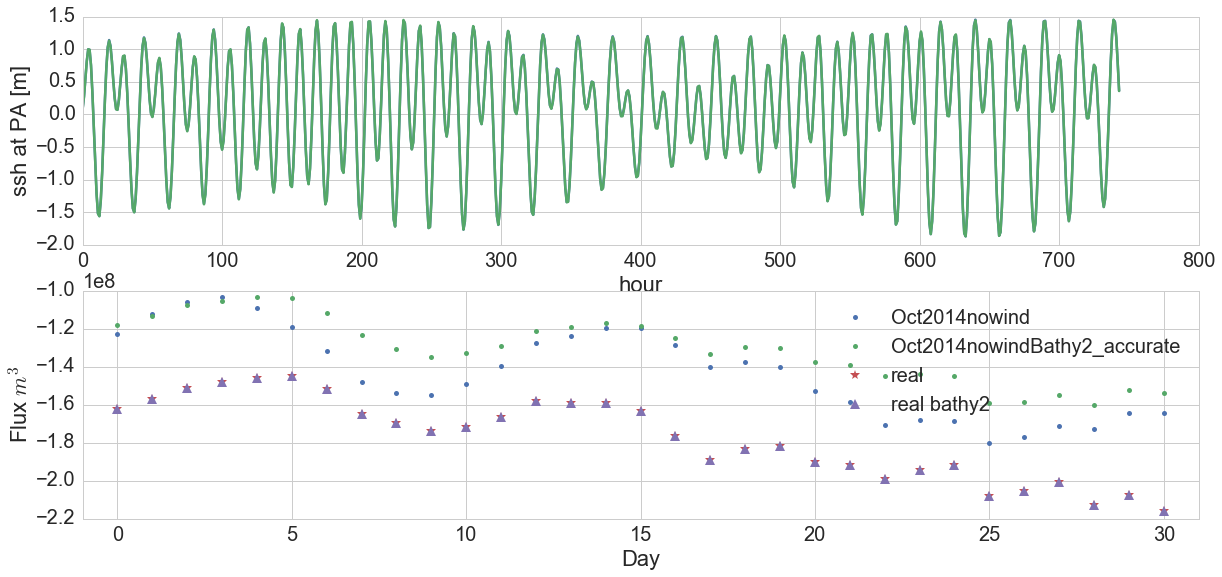

In [11]:
## river mouth transect
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'4',0,743,30,0,fresh_flag='None')

# Check salinity, salt flux and total volume flux close to the original river source

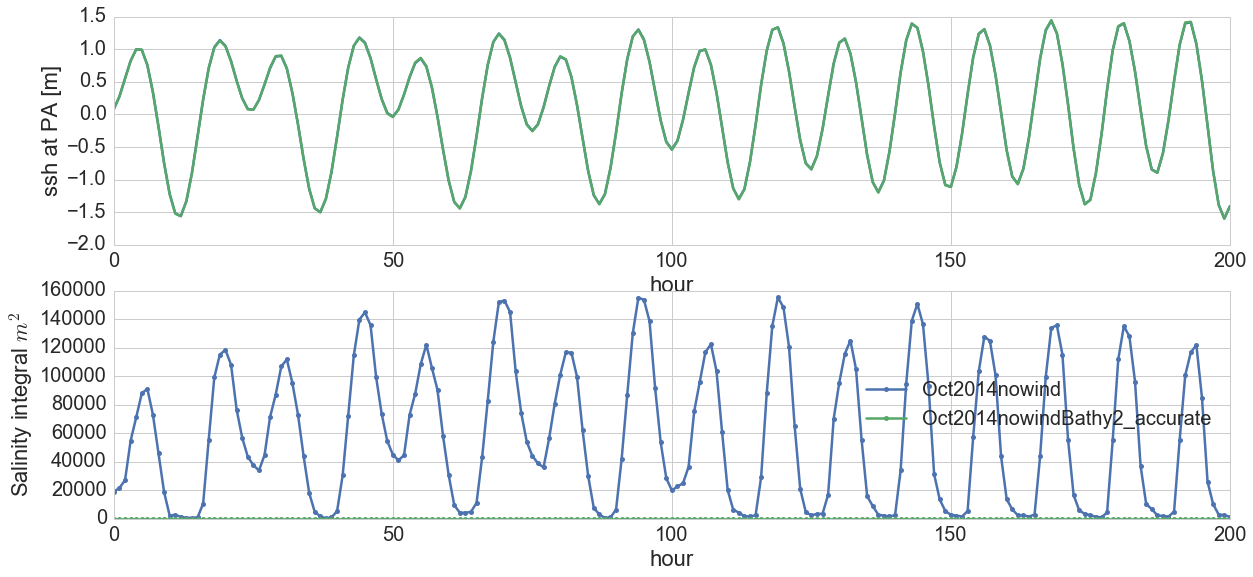

In [12]:
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'8',0,200,30,fresh_flag='saltNoV')

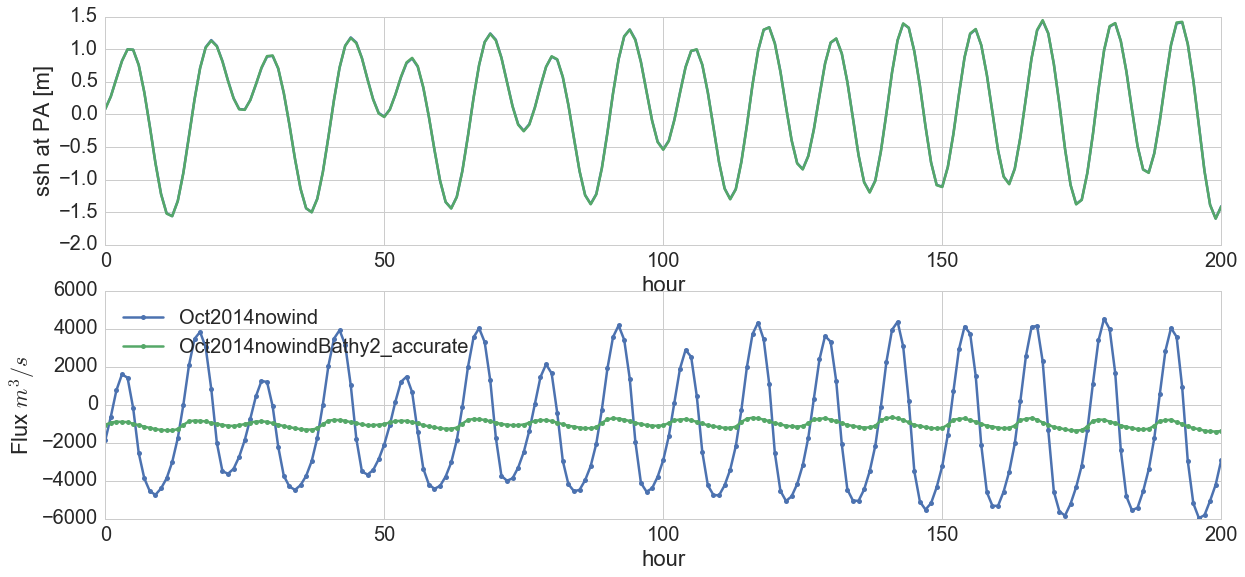

In [13]:
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'8',0,200,30,fresh_flag='None')

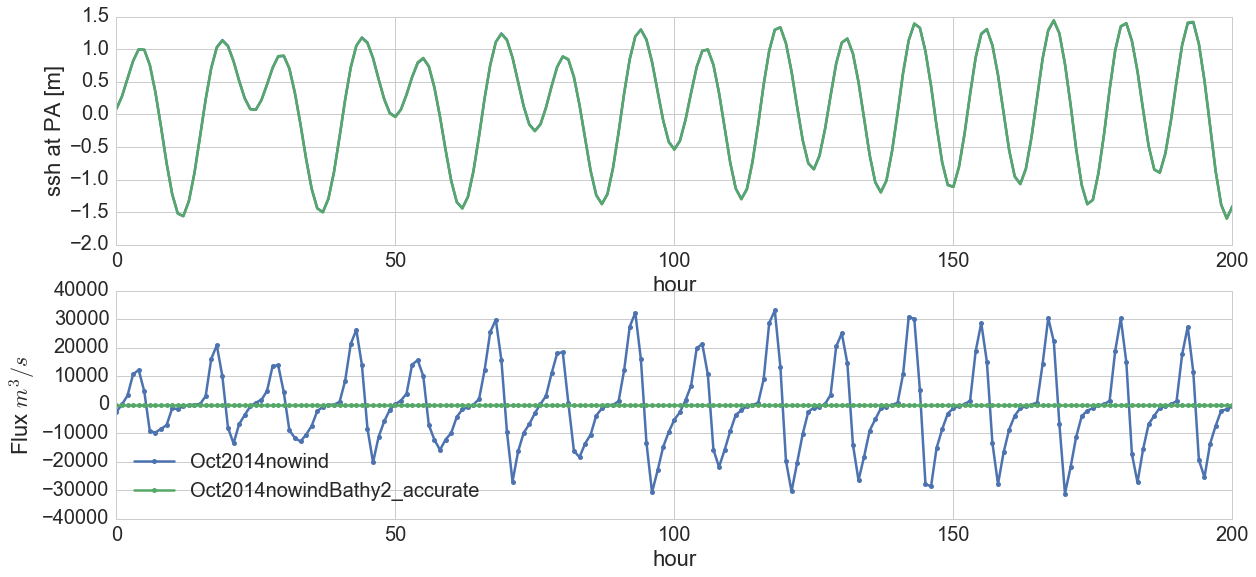

In [14]:
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'8',0,200,30,fresh_flag='salt')

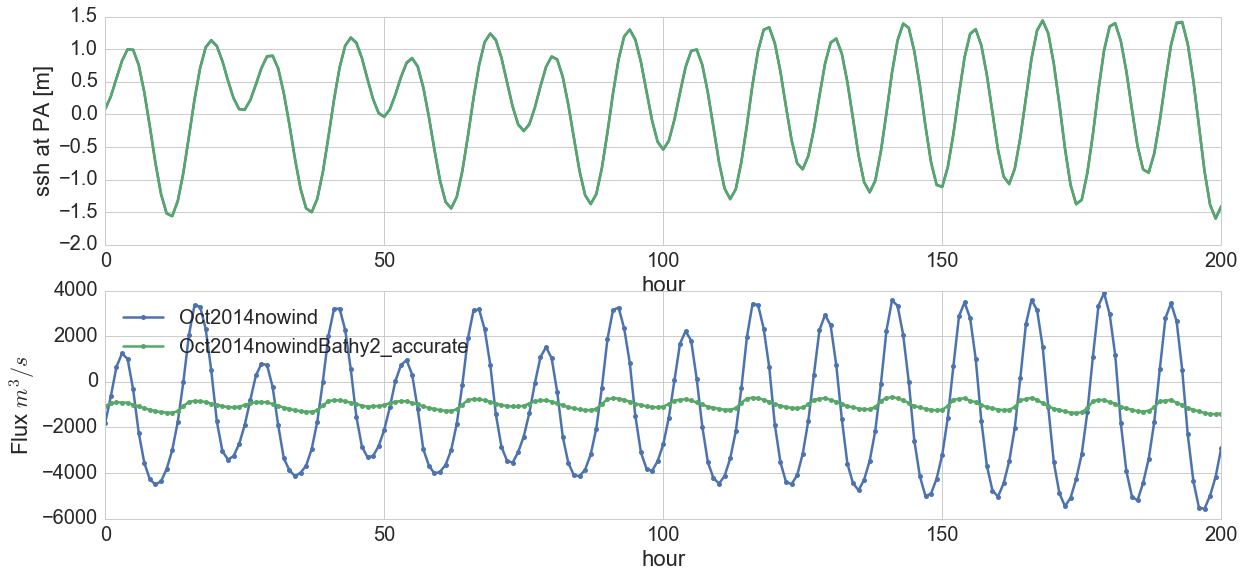

In [15]:
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'8',0,200,30,fresh_flag='fresh')

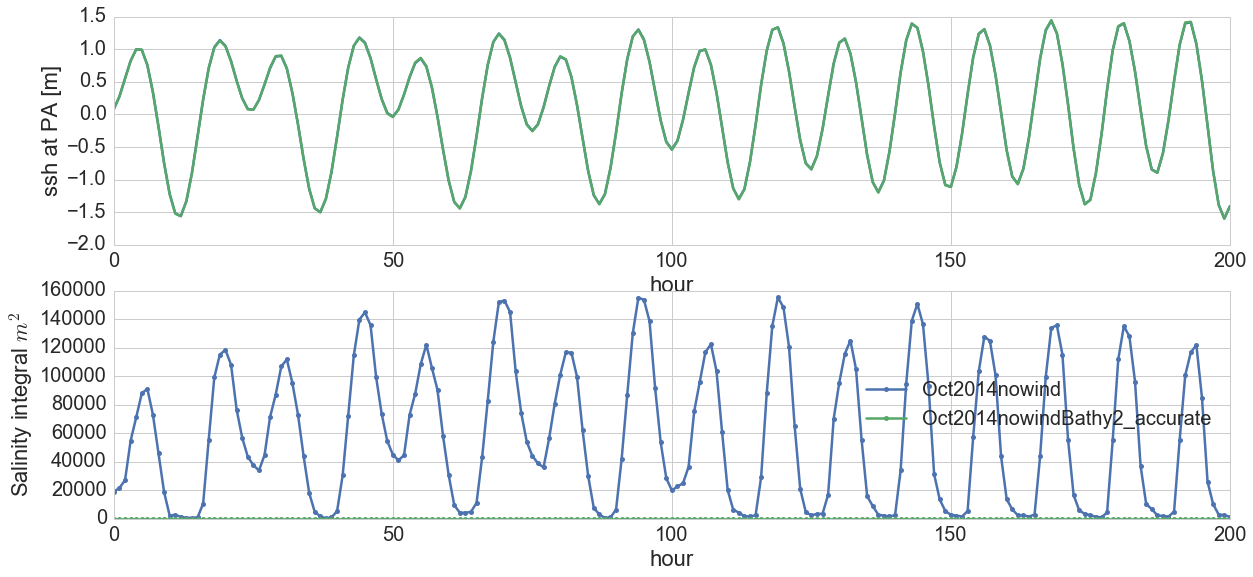

In [46]:
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'8',0,200,30,fresh_flag='saltNoV')

/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d01.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d02.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d03.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d04.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d05.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d06.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d07.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d08.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d09.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d010.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d011.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d012.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d013.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d014.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014

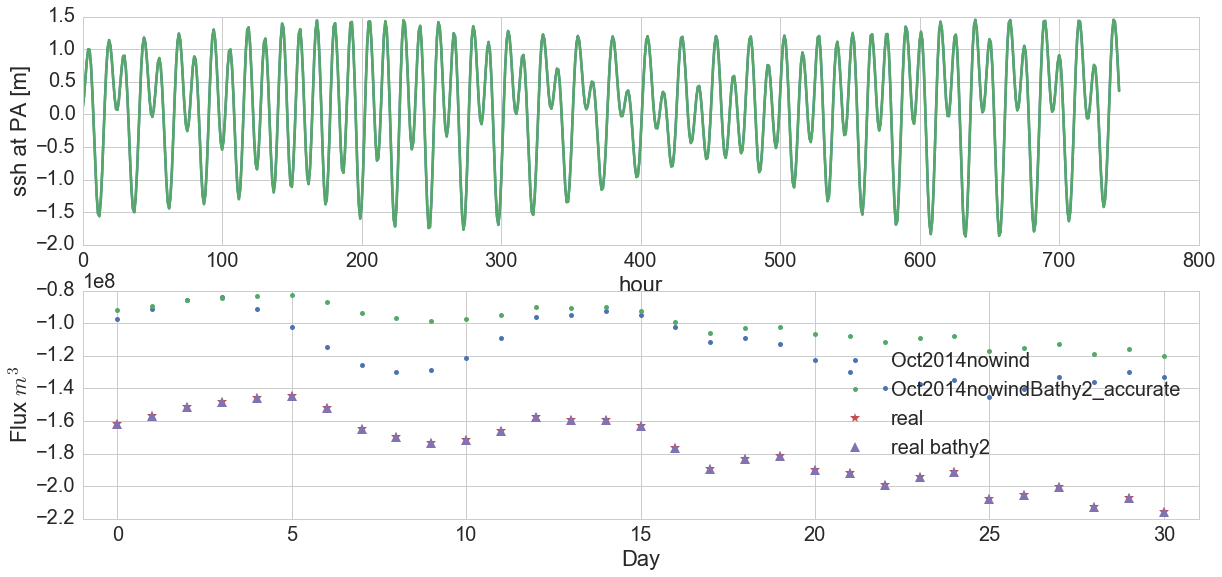

In [86]:
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'8',0,743,30,0,fresh_flag='None')

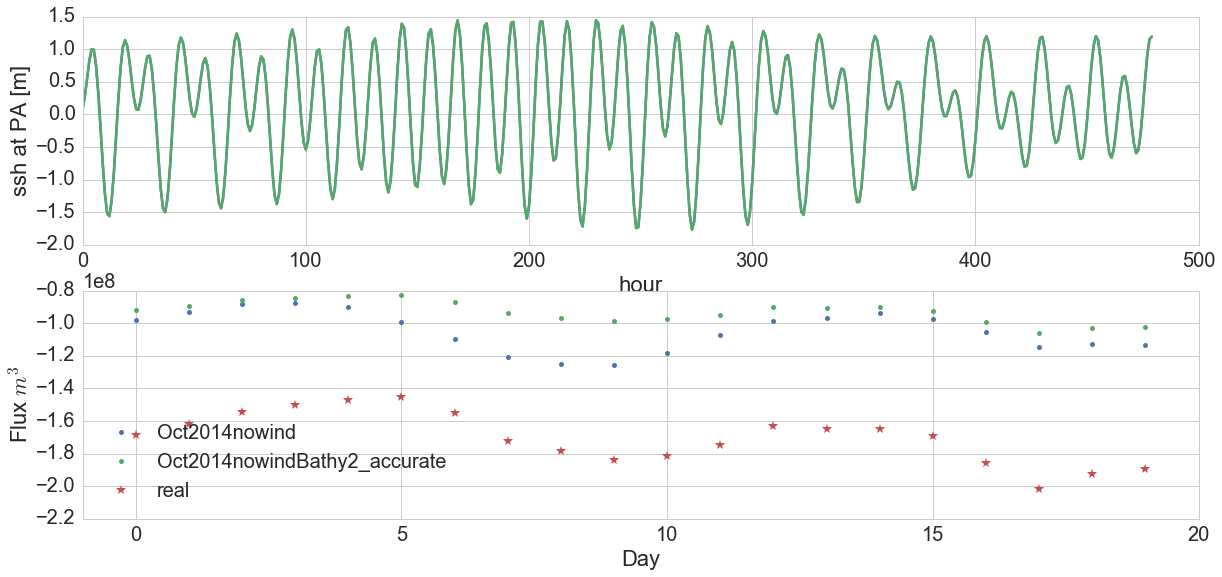

In [16]:
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'8',0,479,30,fresh_flag='fresh')

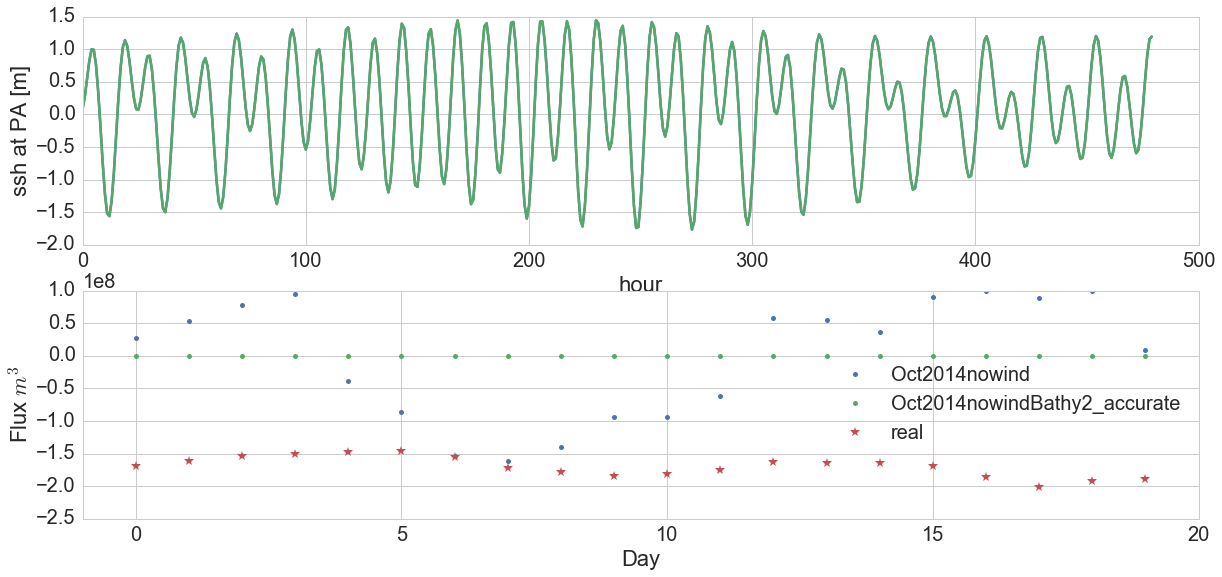

In [17]:
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'8',0,479,30,fresh_flag='salt')

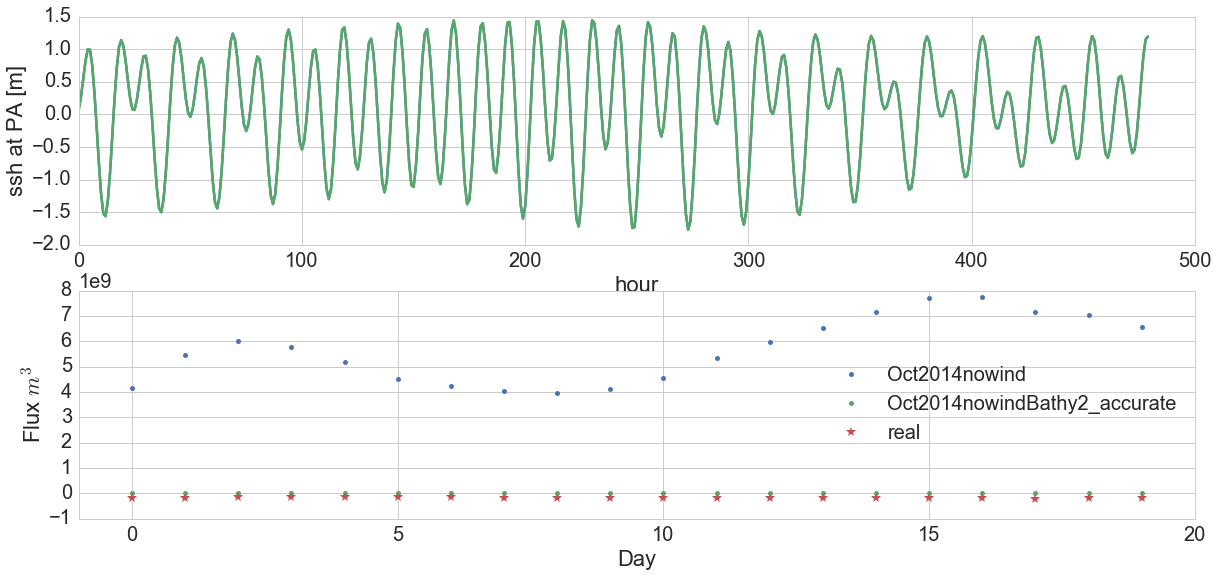

In [47]:
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'8',0,479,30,fresh_flag='saltNoV')

# Check at river mouth

/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d01.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d02.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d03.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d04.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d05.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d06.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d07.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d08.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d09.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d010.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d011.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d012.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d013.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014m10d014.nc
/data/jieliu/MEOPAR/river-treatment/NewRFraserCElse_y2014

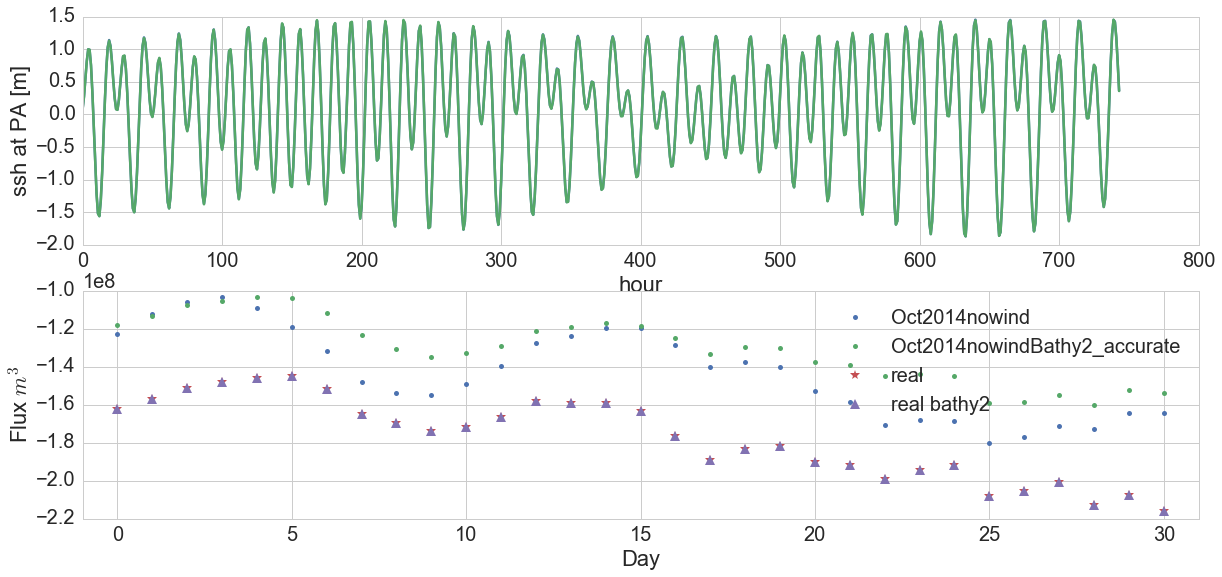

In [87]:
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'4',0,743,30,0,fresh_flag='None')

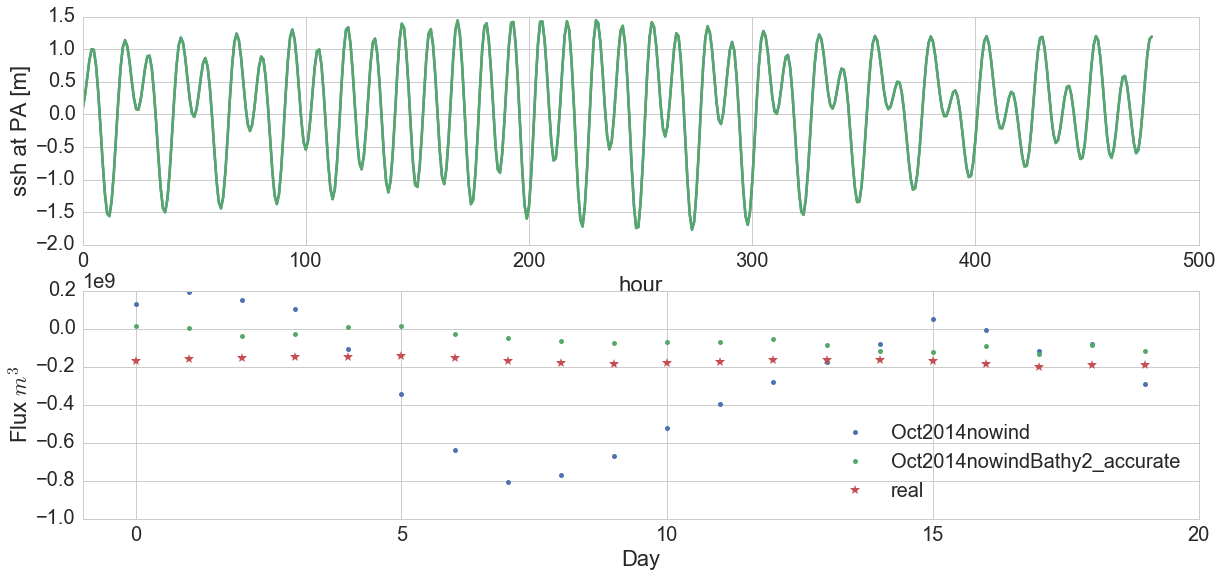

In [19]:
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,30,fresh_flag='salt')

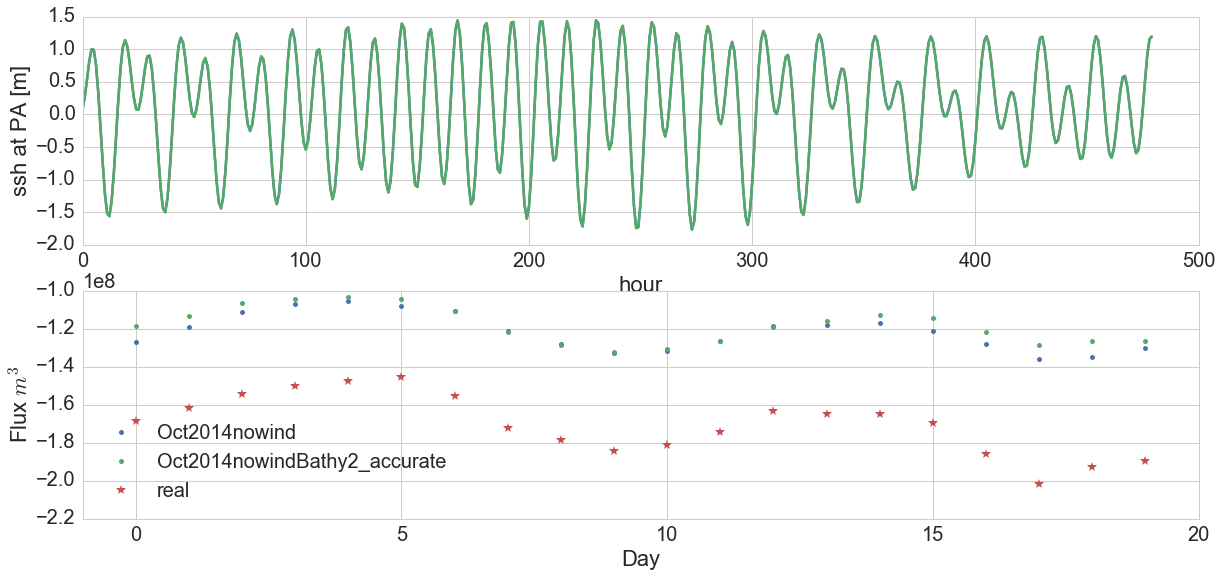

In [20]:
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,30,fresh_flag='fresh')

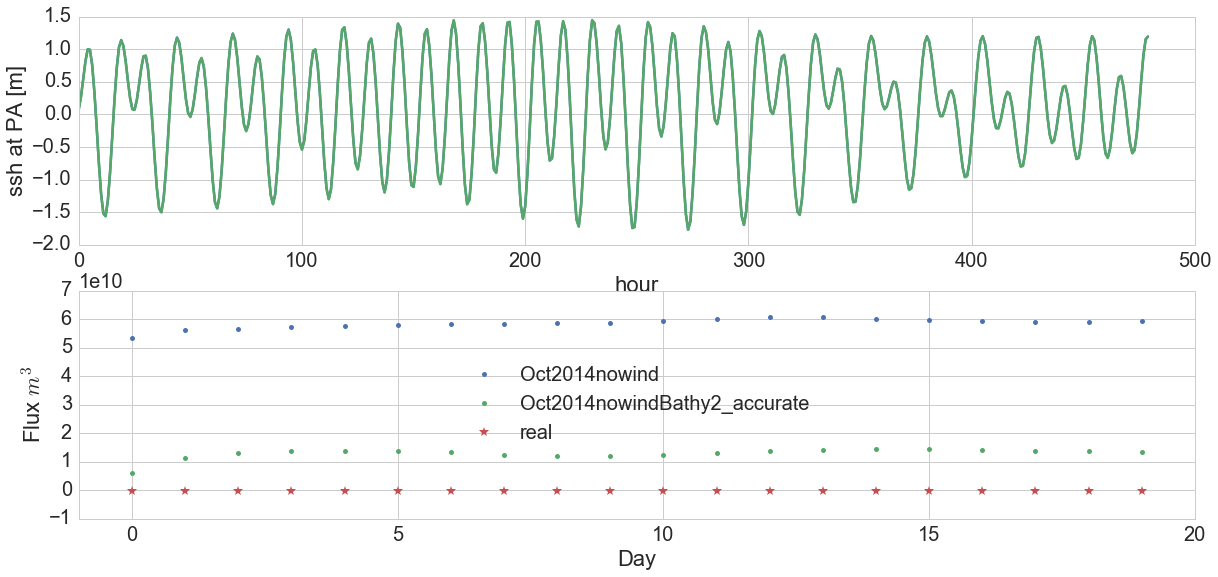

In [21]:
plot_series_transportDaily(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,30,fresh_flag='saltNoV')

look at the hourly variation of volume flux and only salt amount (no times velocity), I didn't expect there is difference between bathy2 and 6 with only river.

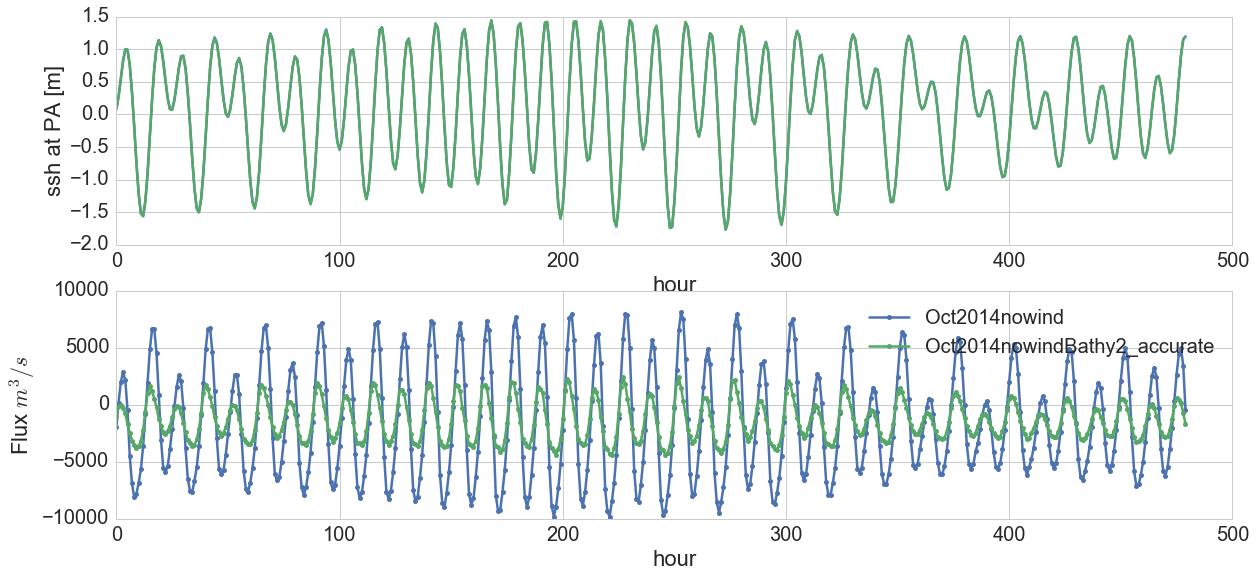

In [22]:
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,30,fresh_flag='None')

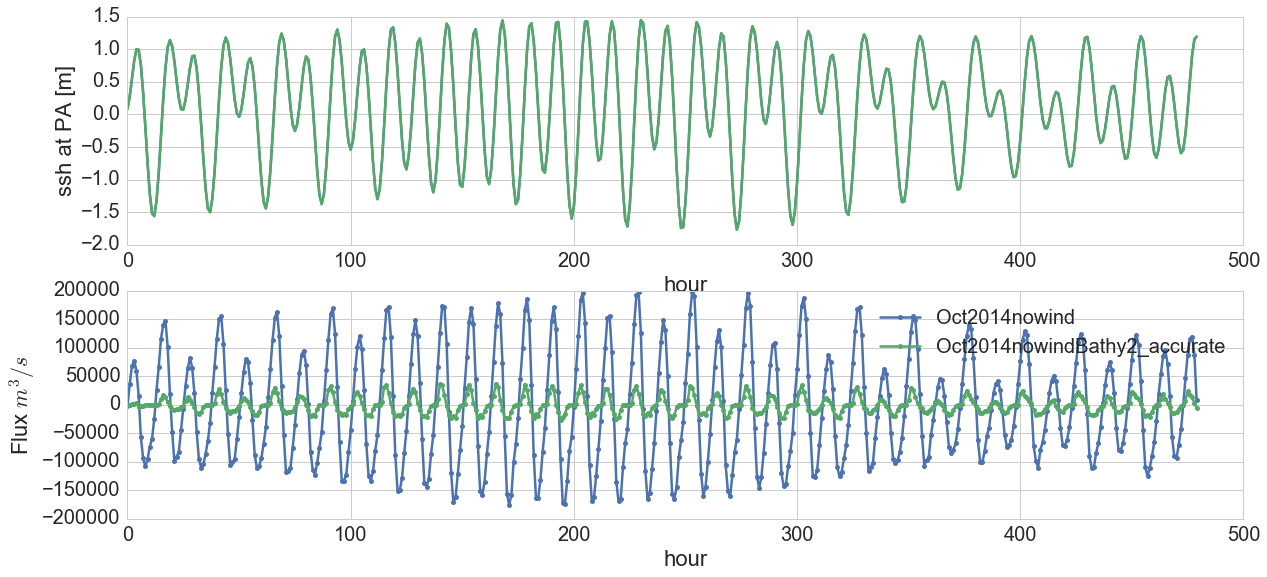

In [23]:
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,30,fresh_flag='salt')

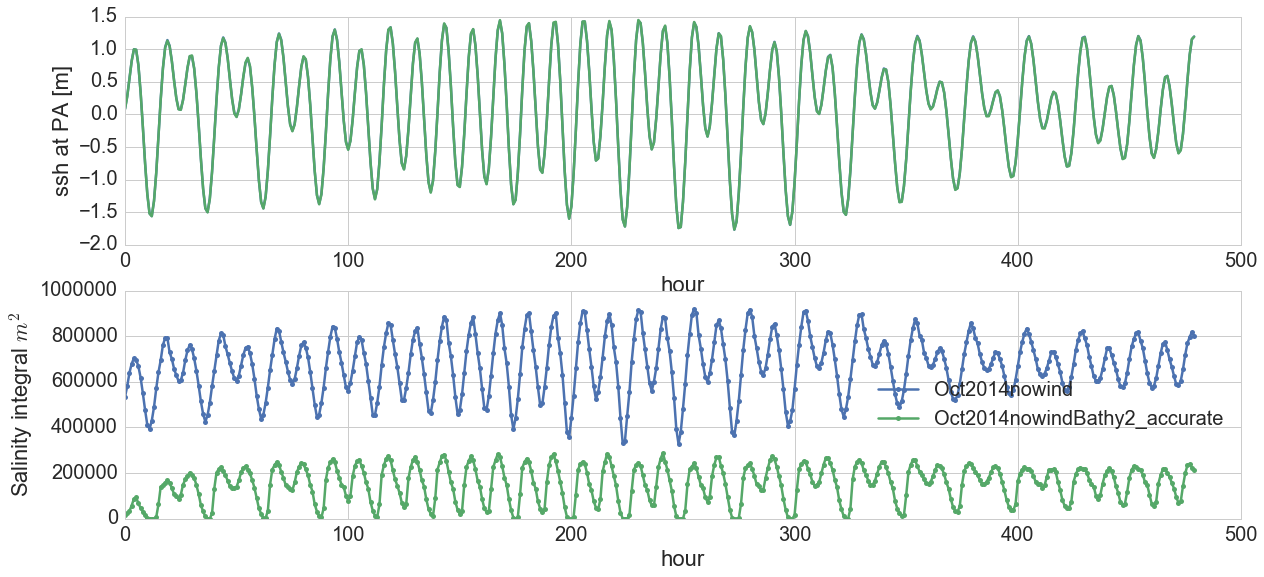

In [24]:
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,30,fresh_flag='saltNoV')

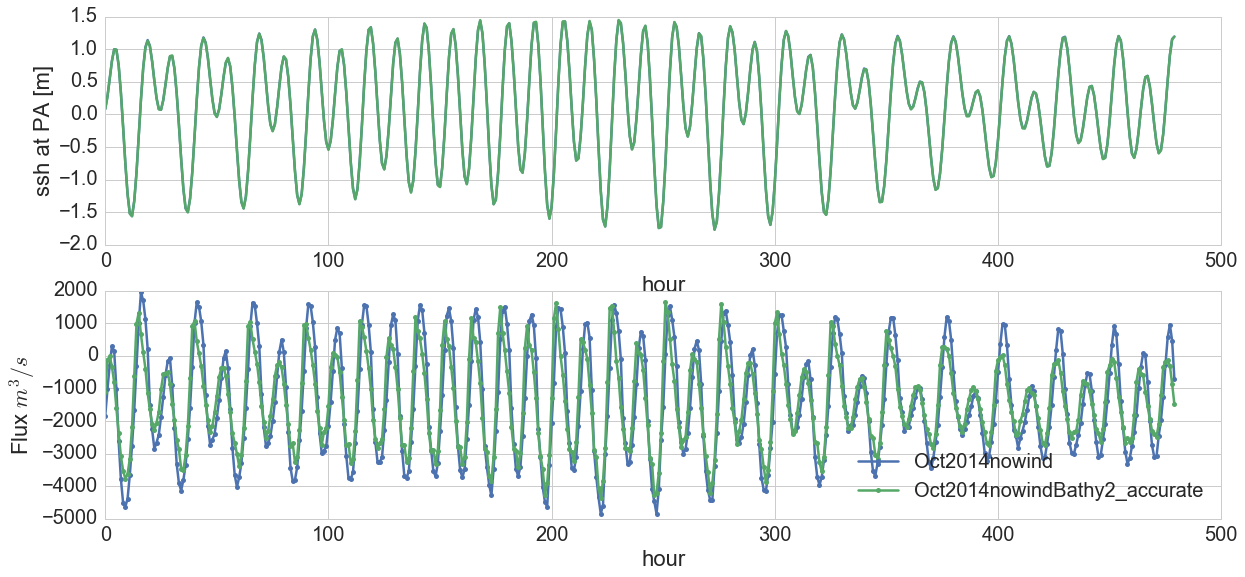

In [25]:
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,30,fresh_flag='fresh')

In [25]:
def plot_series_transportDaily_topfour(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,S0,fresh_flag = 'fresh'):
    """This function is the same with plot_series_transport, except 
    that this is not integral over several days, but only for 
    daily case."""
    trans,trans_surf,trans_to = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,\
                                                                 S0,fresh_flag = fresh_flag)
    trans_topFour = {};
    for pa in paths:
        trans_topFour[pa] = np.nansum(np.nansum(trans[pa][tst:ten+1,0:5],axis = 1),axis = 1)
    
    inte_trans = {}; types = ['Oct2014nowind','Oct2014nowindBathy2_accurate']
    for ty in types:
        inte_trans[ty] = np.zeros((ten+1)/24)
    for i in np.arange(tst,ten+1,24):
        for ty in types:
            inte_trans[ty][i/24] = np.sum(trans_topFour[ty][i:i+24])*3600## intergral individual daily
    fig, axs = plt.subplots(2,1,figsize = (20,9))
    ax = axs[0] ## ssh
    for ty in types:
        ax.plot(ssh[ty][tst:ten+1,86,89],label = ty)
    ax.set_ylabel('ssh at PA [m]')
    ax.set_xlabel('hour')
    ax = axs[1] ## total volumn flux,salt flux and freshwater flux for selected run case and obs
    filename = '/data/dlatorne/SOG-projects/SOG-forcing/ECget/Fraser_flow'
    fraserflow = np.loadtxt(filename)
    real_flows = np.zeros((ten+1)/24);
    for t in np.arange((ten+1)/24): ## default tst -0, from start
        real_flows[t] = -fraserflow[348+t][-1]*24*3600
    for ty in types:
        ax.plot(inte_trans[ty],'.',label = ty,markersize = 10)
        ax.set_ylabel('Flux $m^3$')    
        ax.set_xlim([(tst-24)/24,(ten+1)/24])
    ax.plot(real_flows,'*',label = 'real',markersize = 10)
    ax.legend(loc = 'best')
    ax.set_xlabel('Day')

In [18]:
def plot_series_transport_topfour(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,S0,fresh_flag = 'fresh'):
    """
    
    """
    trans,trans_surf,trans_to = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,\
                                                                 S0,fresh_flag = fresh_flag)
    trans_topFour = {};
    for pa in paths:
        trans_topFour[pa] = np.nansum(np.nansum(trans[pa][tst:ten+1,0:5],axis = 1),axis = 1)
    types = ['Oct2014nowind','Oct2014nowindBathy2_accurate']
    fig, axs = plt.subplots(2,1,figsize = (20,9))
    ax = axs[0] ## ssh
    for ty in types:
        ax.plot(ssh[ty][tst:ten+1,86,89],label = ty)
    ax.set_ylabel('ssh at PA [m]')
    ax.set_xlabel('hour')
    ax = axs[1] ## total volumn flux,salt flux and freshwater flux for selected run case and obs
    for ty in types:
        ax.plot(trans_topFour[ty],'-',marker = '.',label = ty,markersize = 10)
        if fresh_flag =='saltNoV':
            ax.set_ylabel('Salinity integral $m^2$')
        else:
            ax.set_ylabel('Flux $m^3/s$')    
    ax.legend(loc = 'best')
    ax.set_xlabel('hour')

# check integral over top 4m at river mouth

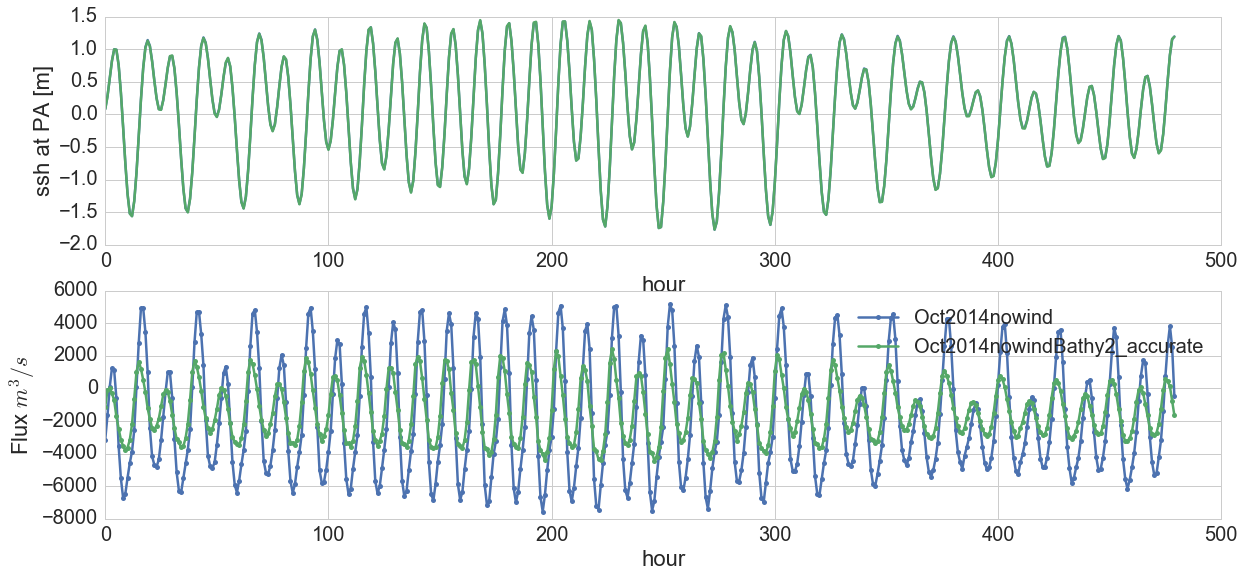

In [19]:
plot_series_transport_topfour(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,30,fresh_flag='None')

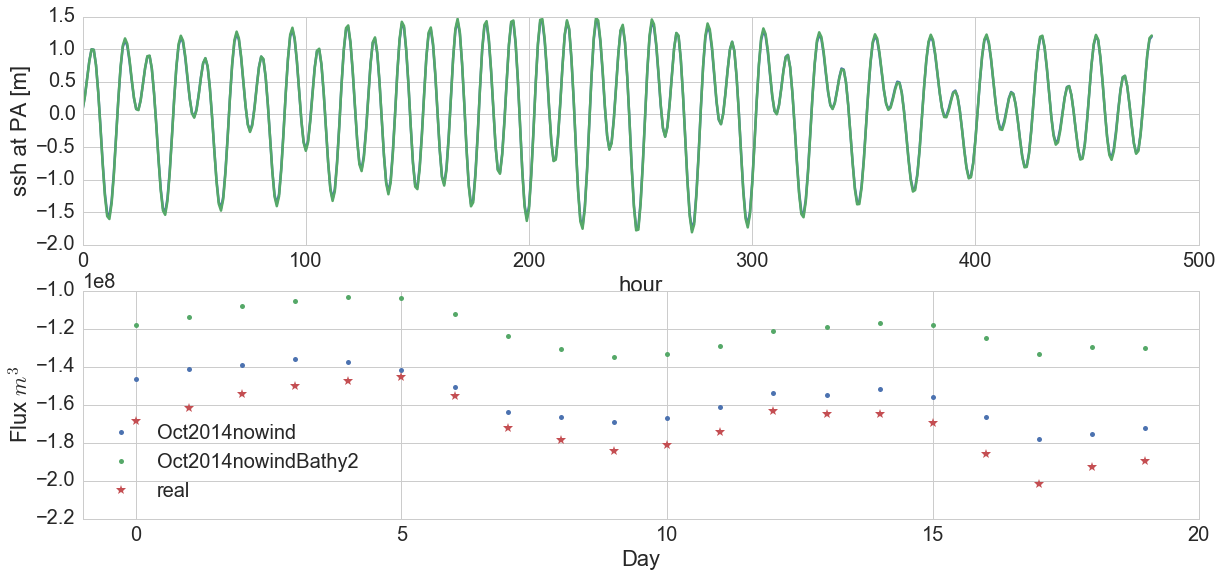

In [26]:
plot_series_transportDaily_topfour(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,30,fresh_flag='None')

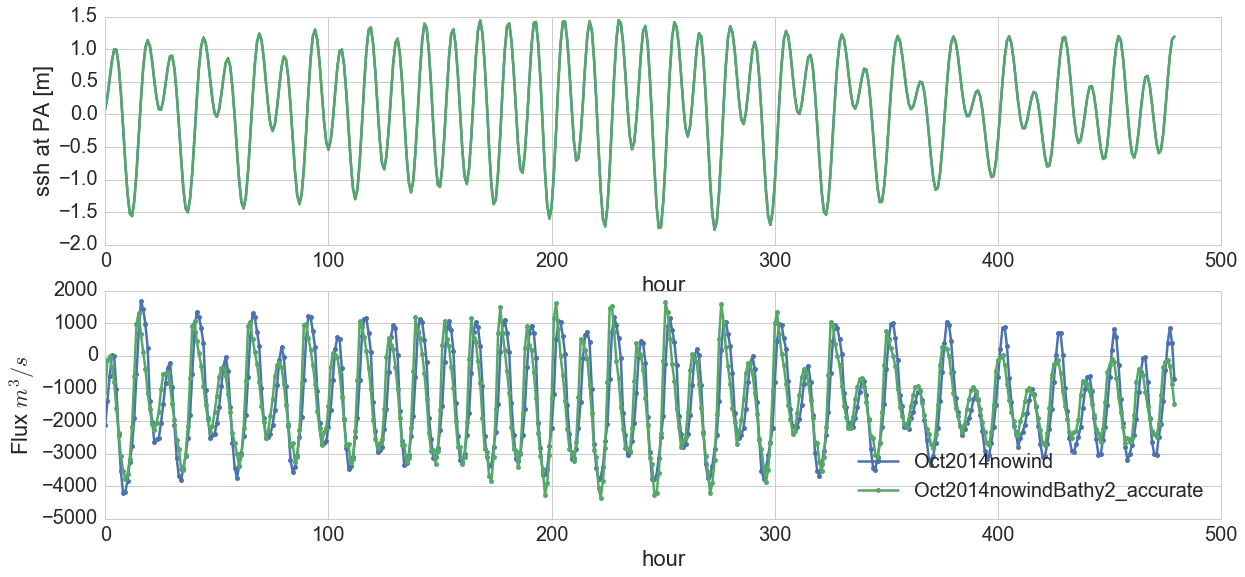

In [20]:
plot_series_transport_topfour(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,30,fresh_flag='fresh')

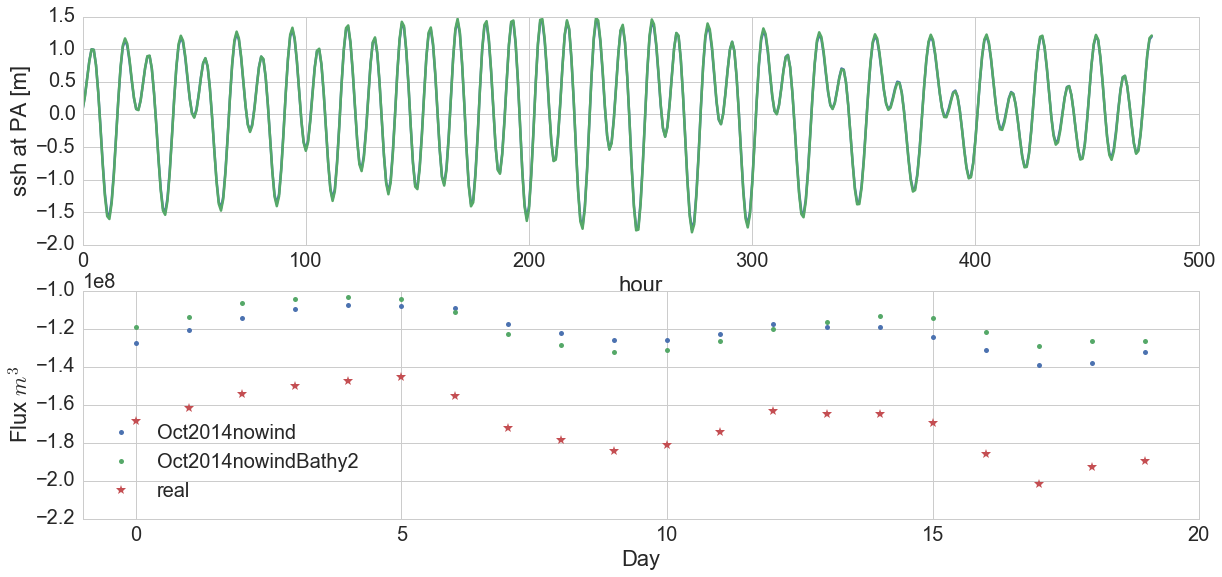

In [27]:
plot_series_transportDaily_topfour(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,30,fresh_flag='fresh')

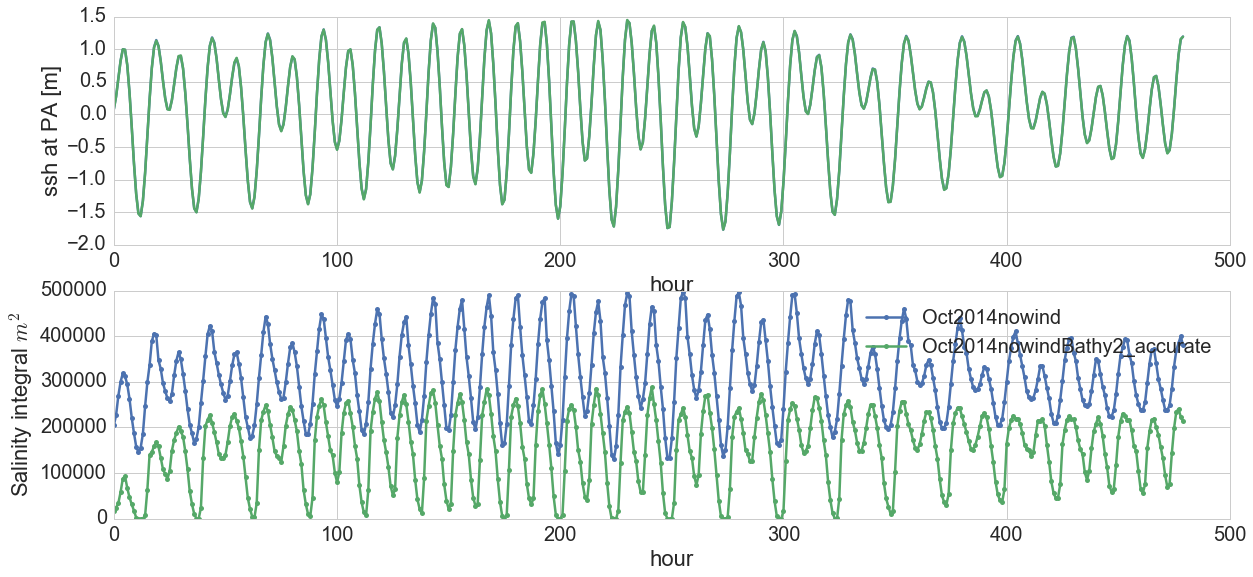

In [21]:
plot_series_transport_topfour(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,30,fresh_flag='saltNoV')

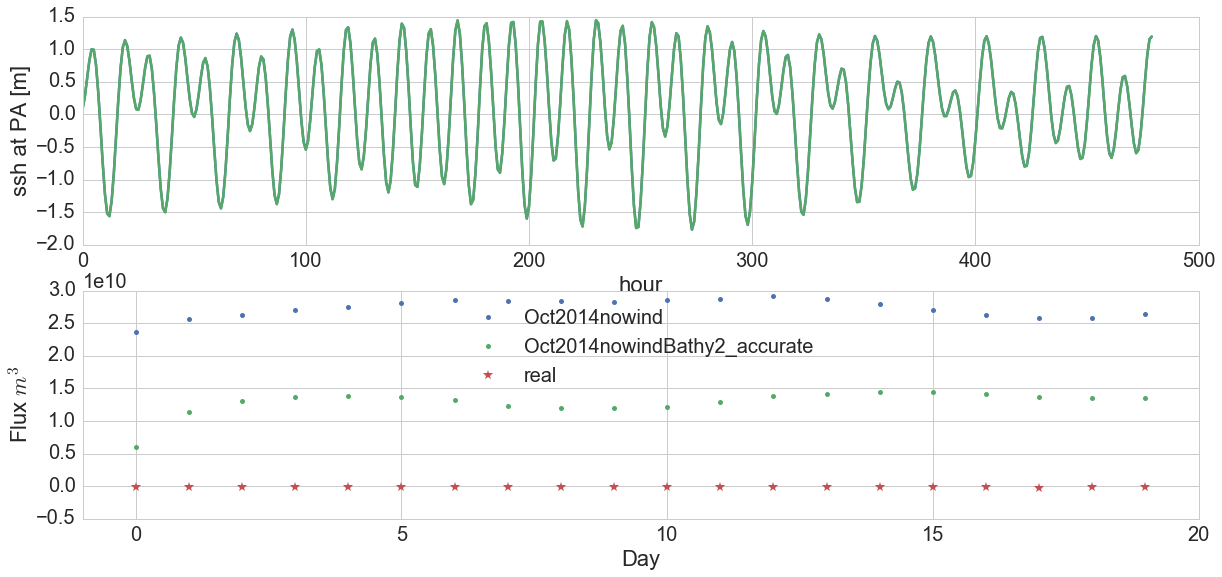

In [26]:
plot_series_transportDaily_topfour(S,U,V,ssh,lon,lat,depU,depV,'4',0,479,30,fresh_flag='saltNoV')

In [10]:
trans,trans_surf,trans_to=transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'4',0,719,30,fresh_flag='None')

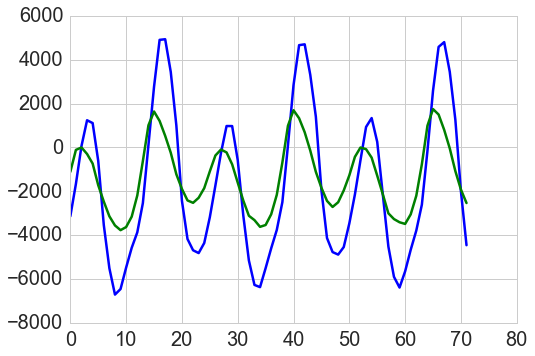

In [17]:
plt.plot(np.nansum(np.nansum(trans['Oct2014nowind'][0:72,0:5,:],axis = 1),axis = 1),'b')
plt.plot(np.nansum(np.nansum(trans['Oct2014nowindBathy2_accurate'][0:72,0:5,:],axis = 1),axis = 1),'g')

In [43]:
nowind =np.nansum(np.nansum(trans['Oct2014nowind'][:,:,:],axis = 1),axis = 1)
nowind_2 = np.nansum(np.nansum(trans['Oct2014nowindBathy2_accurate'][:,:,:],axis = 1),axis = 1)

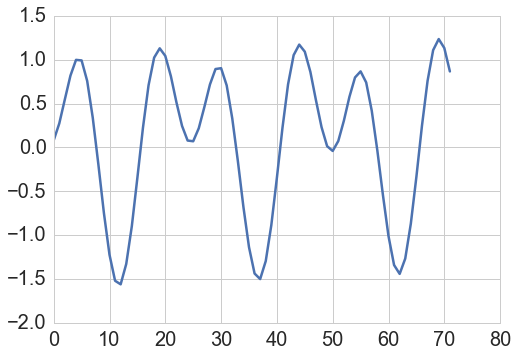

In [56]:
plt.plot(ssh['Oct2014nowindBathy2_accurate'][0:72,86,89])

In [55]:
for start in np.arange(0,696,24):
    end = start+24
    a = np.nanargmax(nowind[start:end])
    b = np.nanargmin(nowind[start:end])
    c = np.nanargmax(nowind_2[start:end])
    d = np.nanargmin(nowind_2[start:end])
    print(a-b,c-d)## first high second low


8 6
8 6
8 5
8 5
8 5
7 5
19 18
8 5
8 5
7 5
8 6
8 6
8 5
9 6
8 6
7 6
7 6
19 18
19 18
20 18
19 17
7 5
8 6
8 6
8 6
8 6
9 6
8 6
8 6


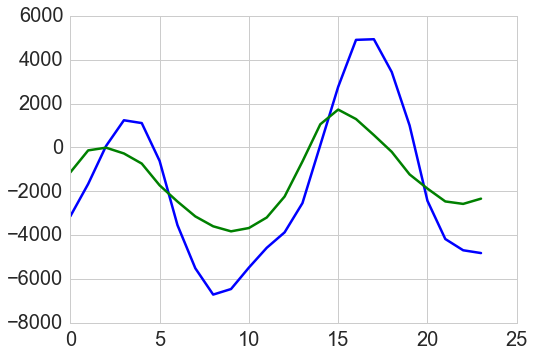

In [30]:
## total flux
plt.plot(np.nansum(np.nansum(transFour['Oct2014nowind'][0:24,0:5,:],axis = 1),axis = 1),'b')
plt.plot(np.nansum(np.nansum(transFour['Oct2014nowindBathy2'][0:24,0:5,:],axis = 1),axis = 1),'g')

# Check integral of volume flux and freshwater over top 4m inside river

In [39]:
trans,trans_surf,trans_to=transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'8',0,719,30,fresh_flag='None')

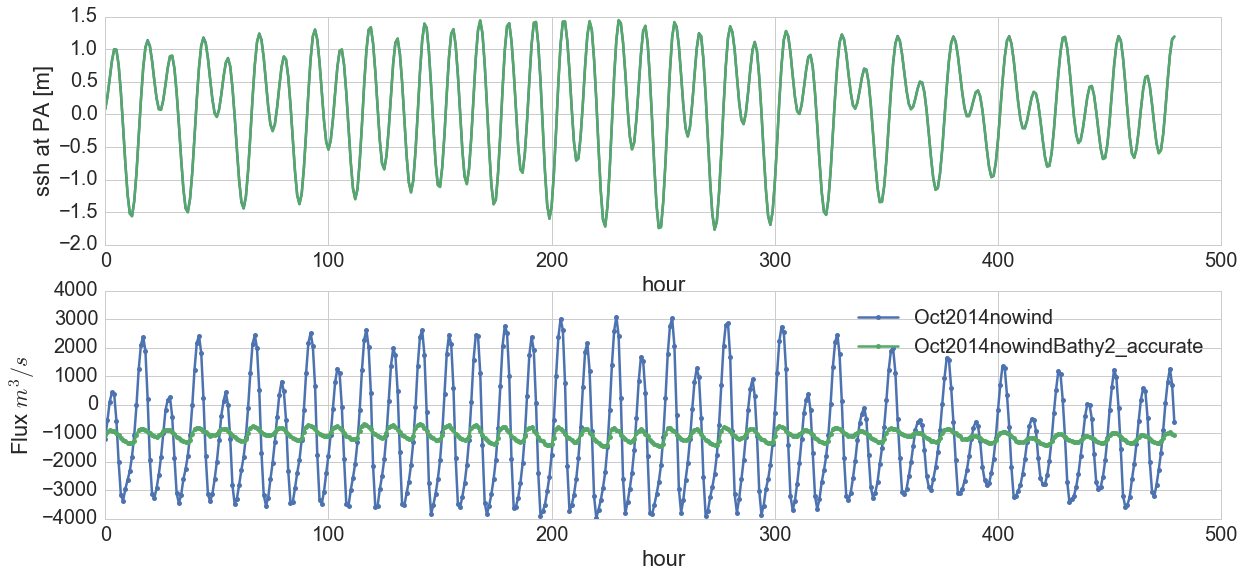

In [43]:
plot_series_transport_topfour(S,U,V,ssh,lon,lat,depU,depV,'8',0,479,30,fresh_flag='None')

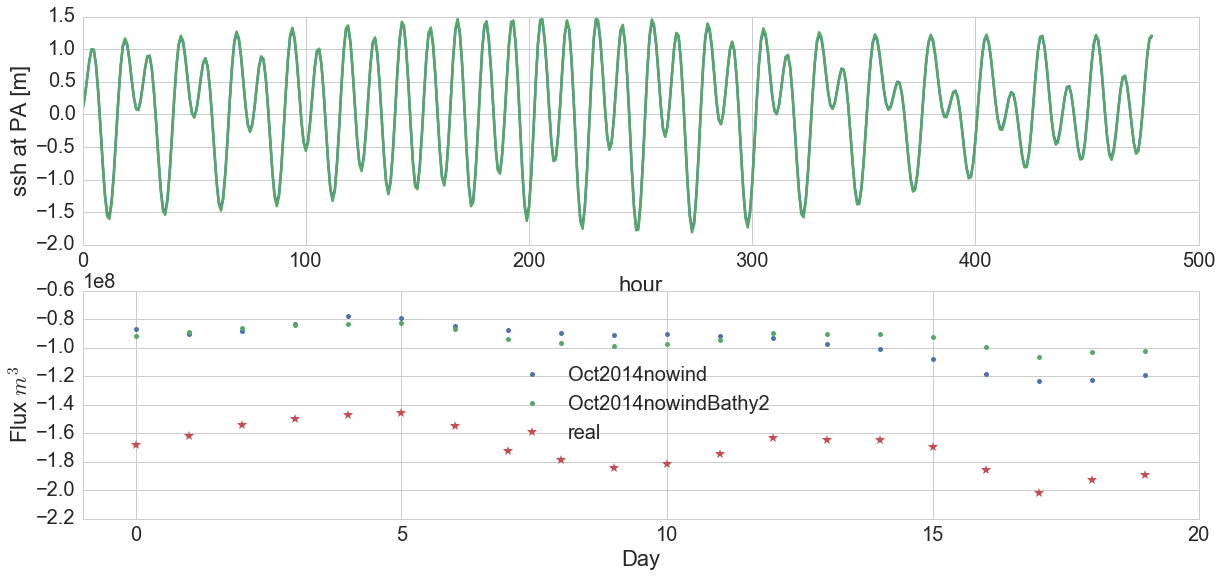

In [40]:
plot_series_transportDaily_topfour(S,U,V,ssh,lon,lat,depU,depV,'8',0,479,30,fresh_flag='None')

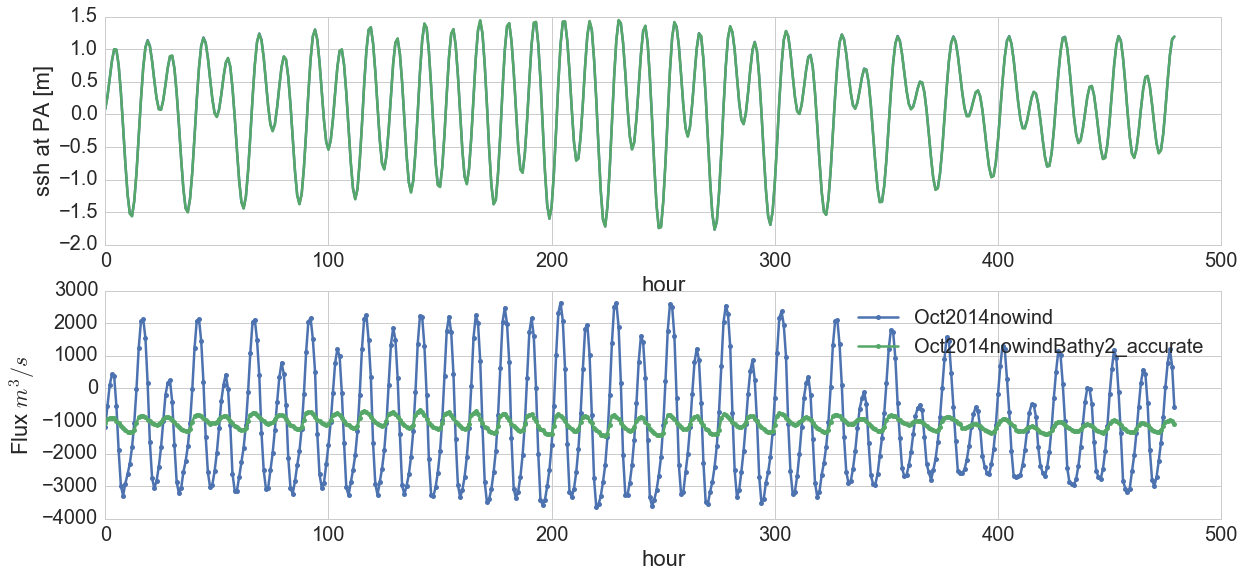

In [45]:
plot_series_transport_topfour(S,U,V,ssh,lon,lat,depU,depV,'8',0,479,30,fresh_flag='fresh')

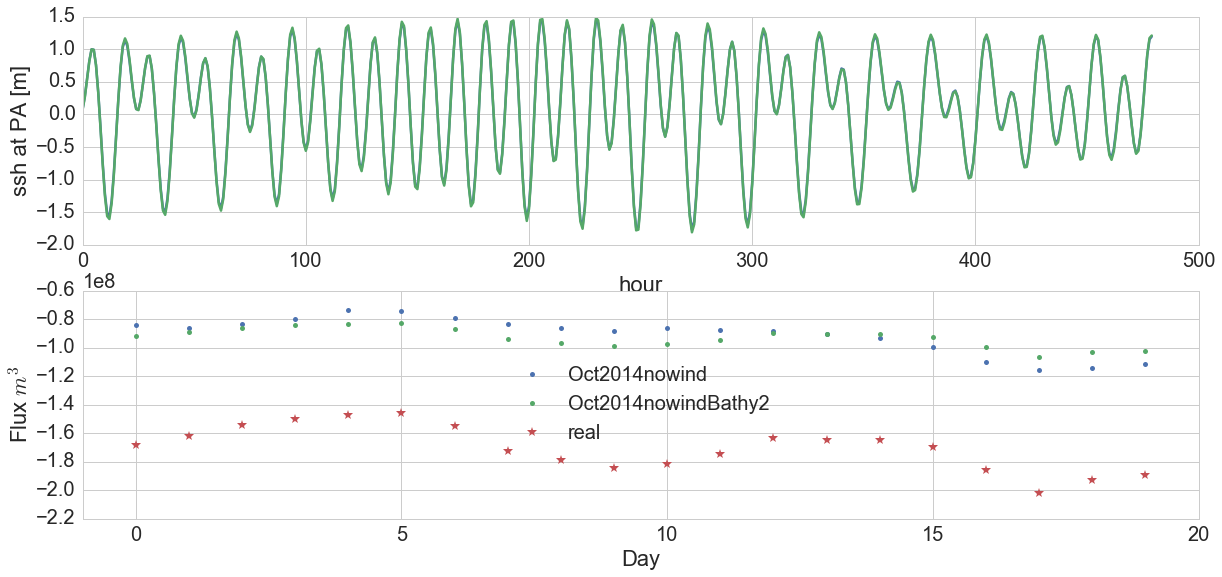

In [41]:
plot_series_transportDaily_topfour(S,U,V,ssh,lon,lat,depU,depV,'8',0,479,30,fresh_flag='fresh')

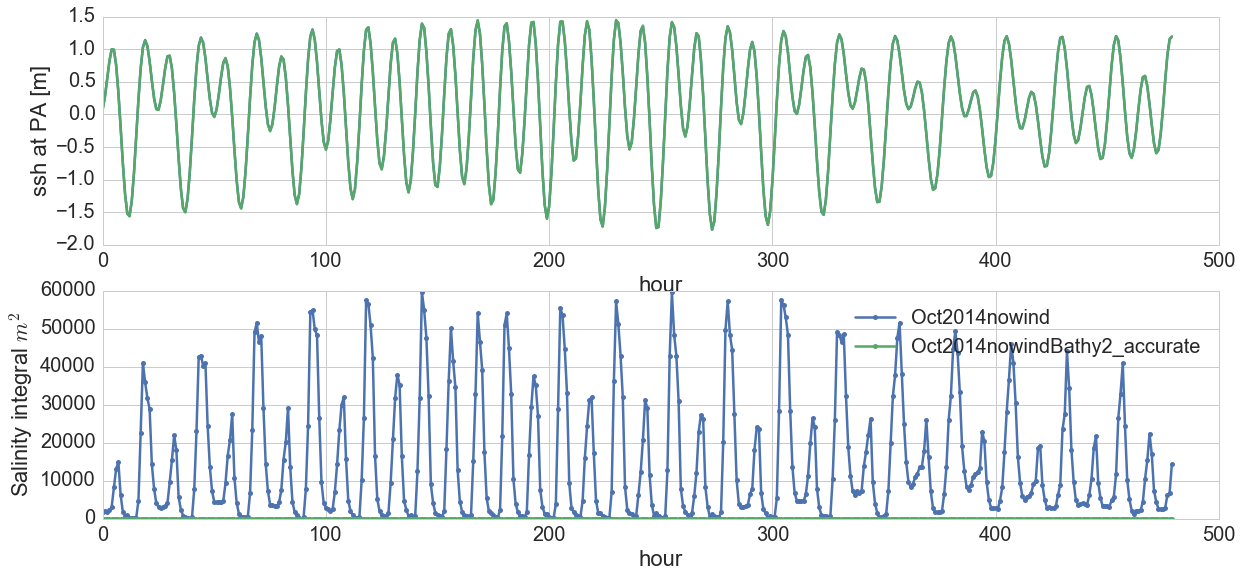

In [48]:
plot_series_transport_topfour(S,U,V,ssh,lon,lat,depU,depV,'8',0,479,30,fresh_flag='saltNoV')

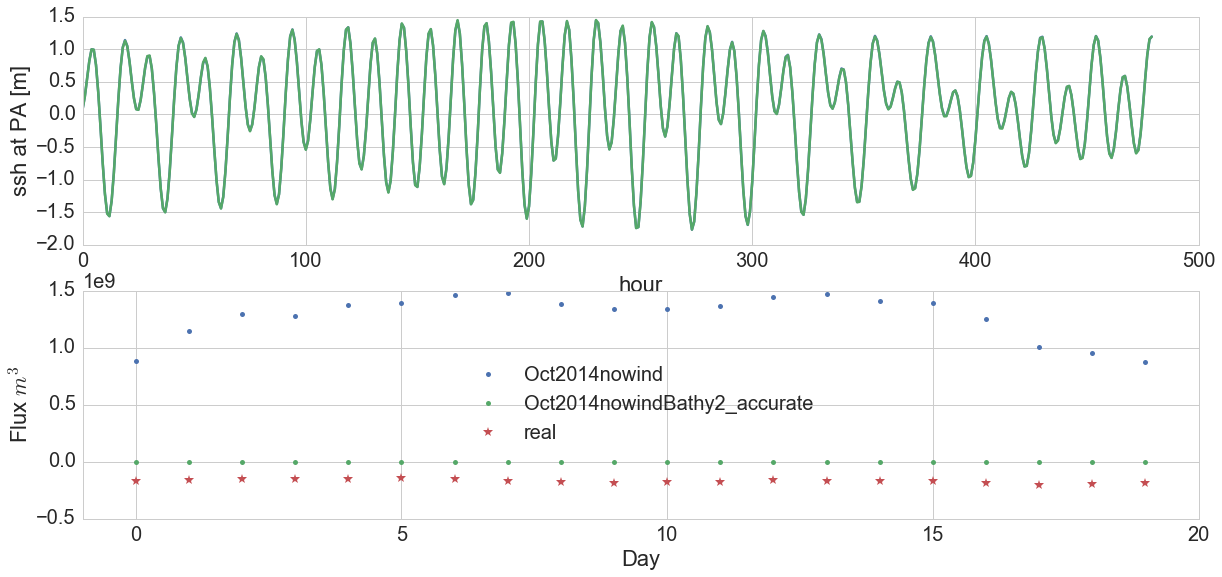

In [49]:
plot_series_transportDaily_topfour(S,U,V,ssh,lon,lat,depU,depV,'8',0,479,30,fresh_flag='saltNoV')

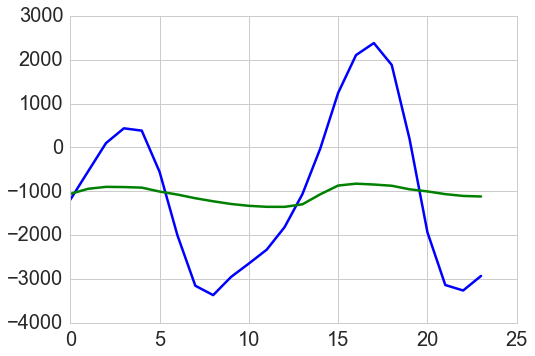

In [42]:
## total flux
plt.plot(np.nansum(np.nansum(trans['Oct2014nowind'][0:24,0:5,:],axis = 1),axis = 1),'b')
plt.plot(np.nansum(np.nansum(trans['Oct2014nowindBathy2'][0:24,0:5,:],axis = 1),axis = 1),'g')

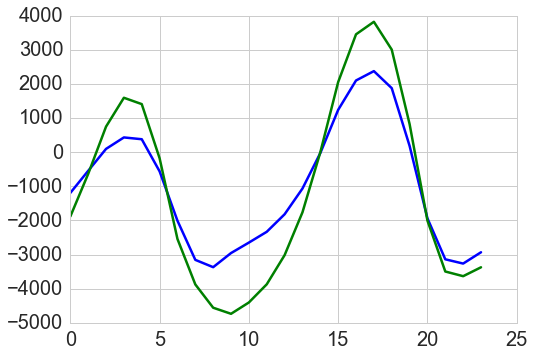

In [43]:
plt.plot(np.nansum(np.nansum(trans['Oct2014nowind'][0:24,0:5,:],axis = 1),axis = 1),'b')
plt.plot(np.nansum(np.nansum(trans['Oct2014nowind'][0:24,:,:],axis = 1),axis = 1),'g')

In [44]:
transFre,trans_surfFre,trans_toFre=transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'8',0,719,30,fresh_flag='fresh')

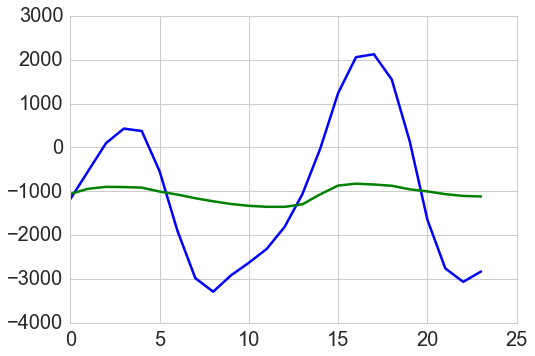

In [45]:
## freshwater flux
plt.plot(np.nansum(np.nansum(transFre['Oct2014nowind'][0:24,0:5,:],axis = 1),axis = 1),'b')
plt.plot(np.nansum(np.nansum(transFre['Oct2014nowindBathy2'][0:24,0:5,:],axis = 1),axis = 1),'g')

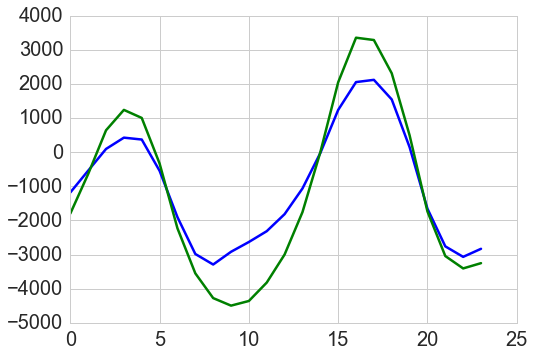

In [46]:
plt.plot(np.nansum(np.nansum(transFre['Oct2014nowind'][0:24,0:5,:],axis = 1),axis = 1),'b')
plt.plot(np.nansum(np.nansum(transFre['Oct2014nowind'][0:24,:,:],axis = 1),axis = 1),'g')

# Check salinity at the mouth between bathy6 &2, between upper 4m and below

In [33]:
def check_Salinity_Profile(t,j,i,t1,t2):
    """Check salinity profile at the river mouth transect"""
    fig,axs = plt.subplots(1,4,figsize = (18,5))
    ax = axs[0]
    S1 = np.ma.masked_values(S['Oct2014nowind'][t,:,j,i],0)
    S2 = np.ma.masked_values(S['Oct2014nowindBathy2_accurate'][t,:,j,i],0)
    ax.plot(S1,depT,color = 'b',label = 'bathy6')
    ax.plot(S2,depT,color = 'g',label = 'bathy2')
    ax.set_ylim([depT[10],depT[0]])
    ax.legend(loc = 'best')
    ax = axs[1]
    U1 = np.ma.masked_values(U['Oct2014nowind'][t,:,j,i],0)
    U2 = np.ma.masked_values(U['Oct2014nowindBathy2_accurate'][t,:,j,i],0)
    ax.plot(U1,depT,color = 'b',label = 'bathy6')
    ax.plot(U2,depT,color = 'g',label = 'bathy2')
    ax.legend(loc = 'best')
    ax.set_ylim([depT[10],depT[0]])
    ax = axs[2]
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
    ax.plot(X[j,i],Y[j,i],'y^')
    ax.set_xlim([-123.4,-122.5])
    ax.set_ylim([48.95,49.2])
    ax = axs[3]
    ax.plot(np.arange(t1,t2+1),ssh['Oct2014nowind'][t1:t2+1,86,89])
    ax.plot(t,ssh['Oct2014nowind'][t,86,89],'r*',markersize = 13)

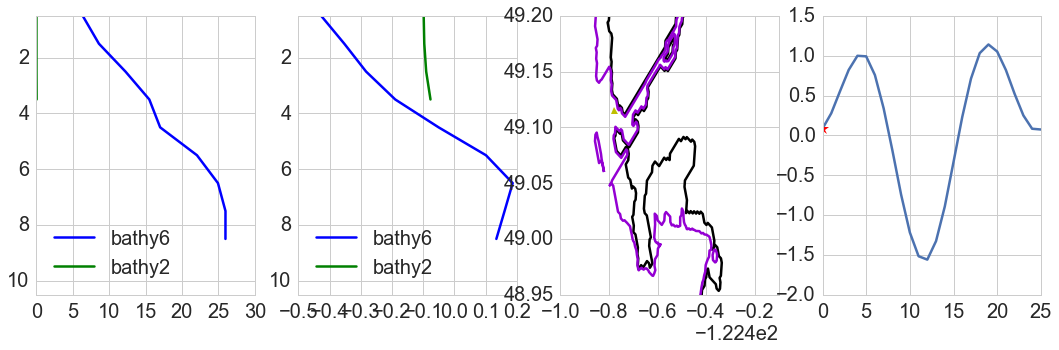

In [35]:
## start
check_Salinity_Profile(0,41,72,0,25)

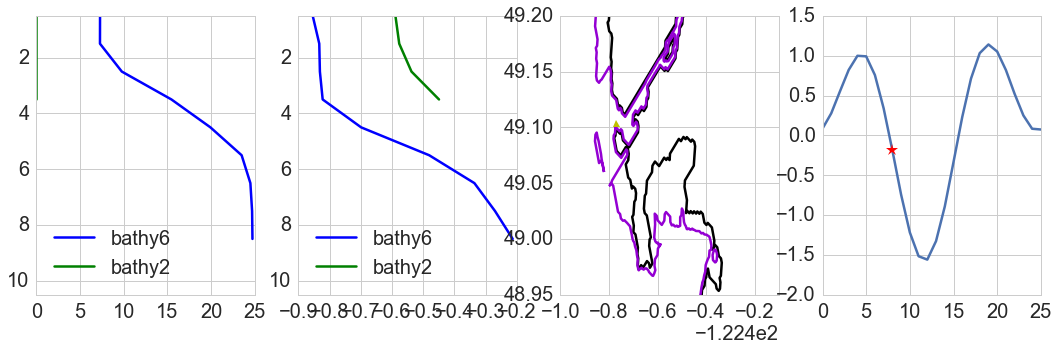

In [36]:
check_Salinity_Profile(8,38,72,0,25)

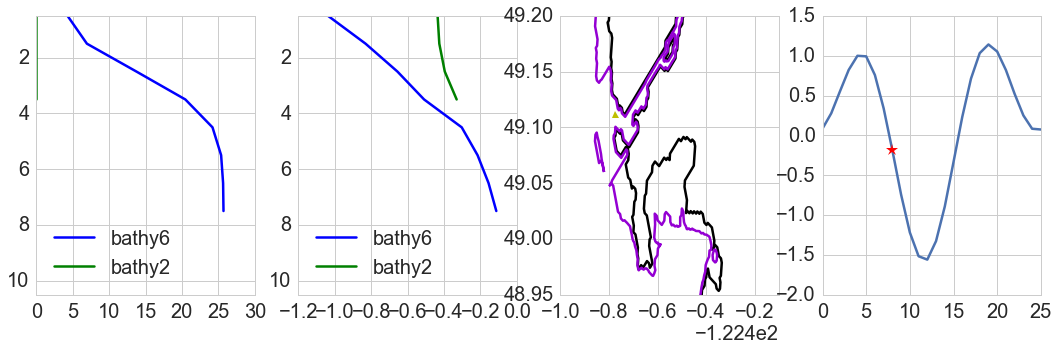

In [37]:
check_Salinity_Profile(8,40,72,0,25)

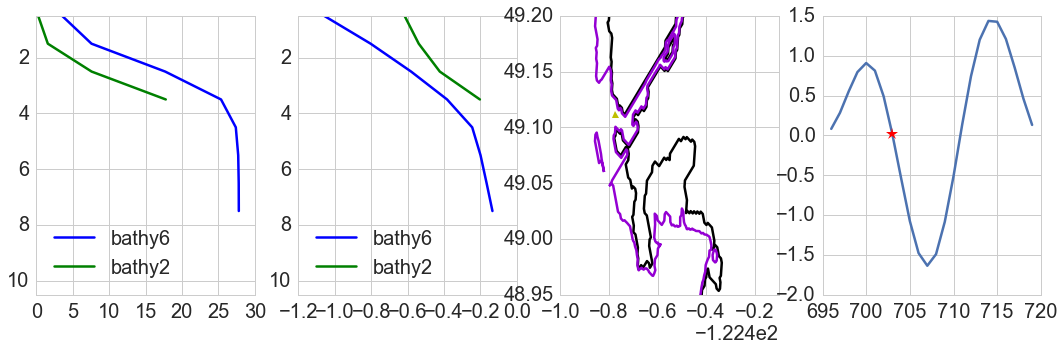

In [38]:
## end
check_Salinity_Profile(703,40,72,696,719)

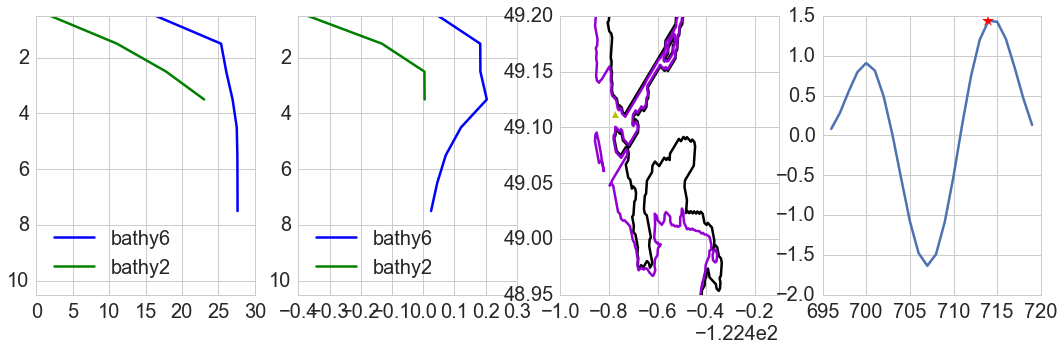

In [64]:
check_Salinity_Profile(714,40,72,696,719)

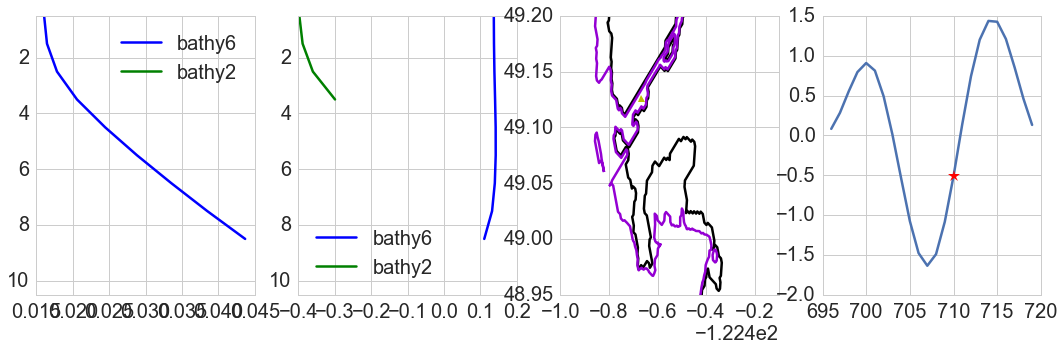

In [68]:
check_Salinity_Profile(710,35,90,696,719)

* Hypothesis of stronger cross-strait flows, then stronger shear, then more vertical mixing, fails! Cause the shear is weaker in stronger cross-strait flow case. But more likely that the stronger u flows move upper 3~4 m depths all together.

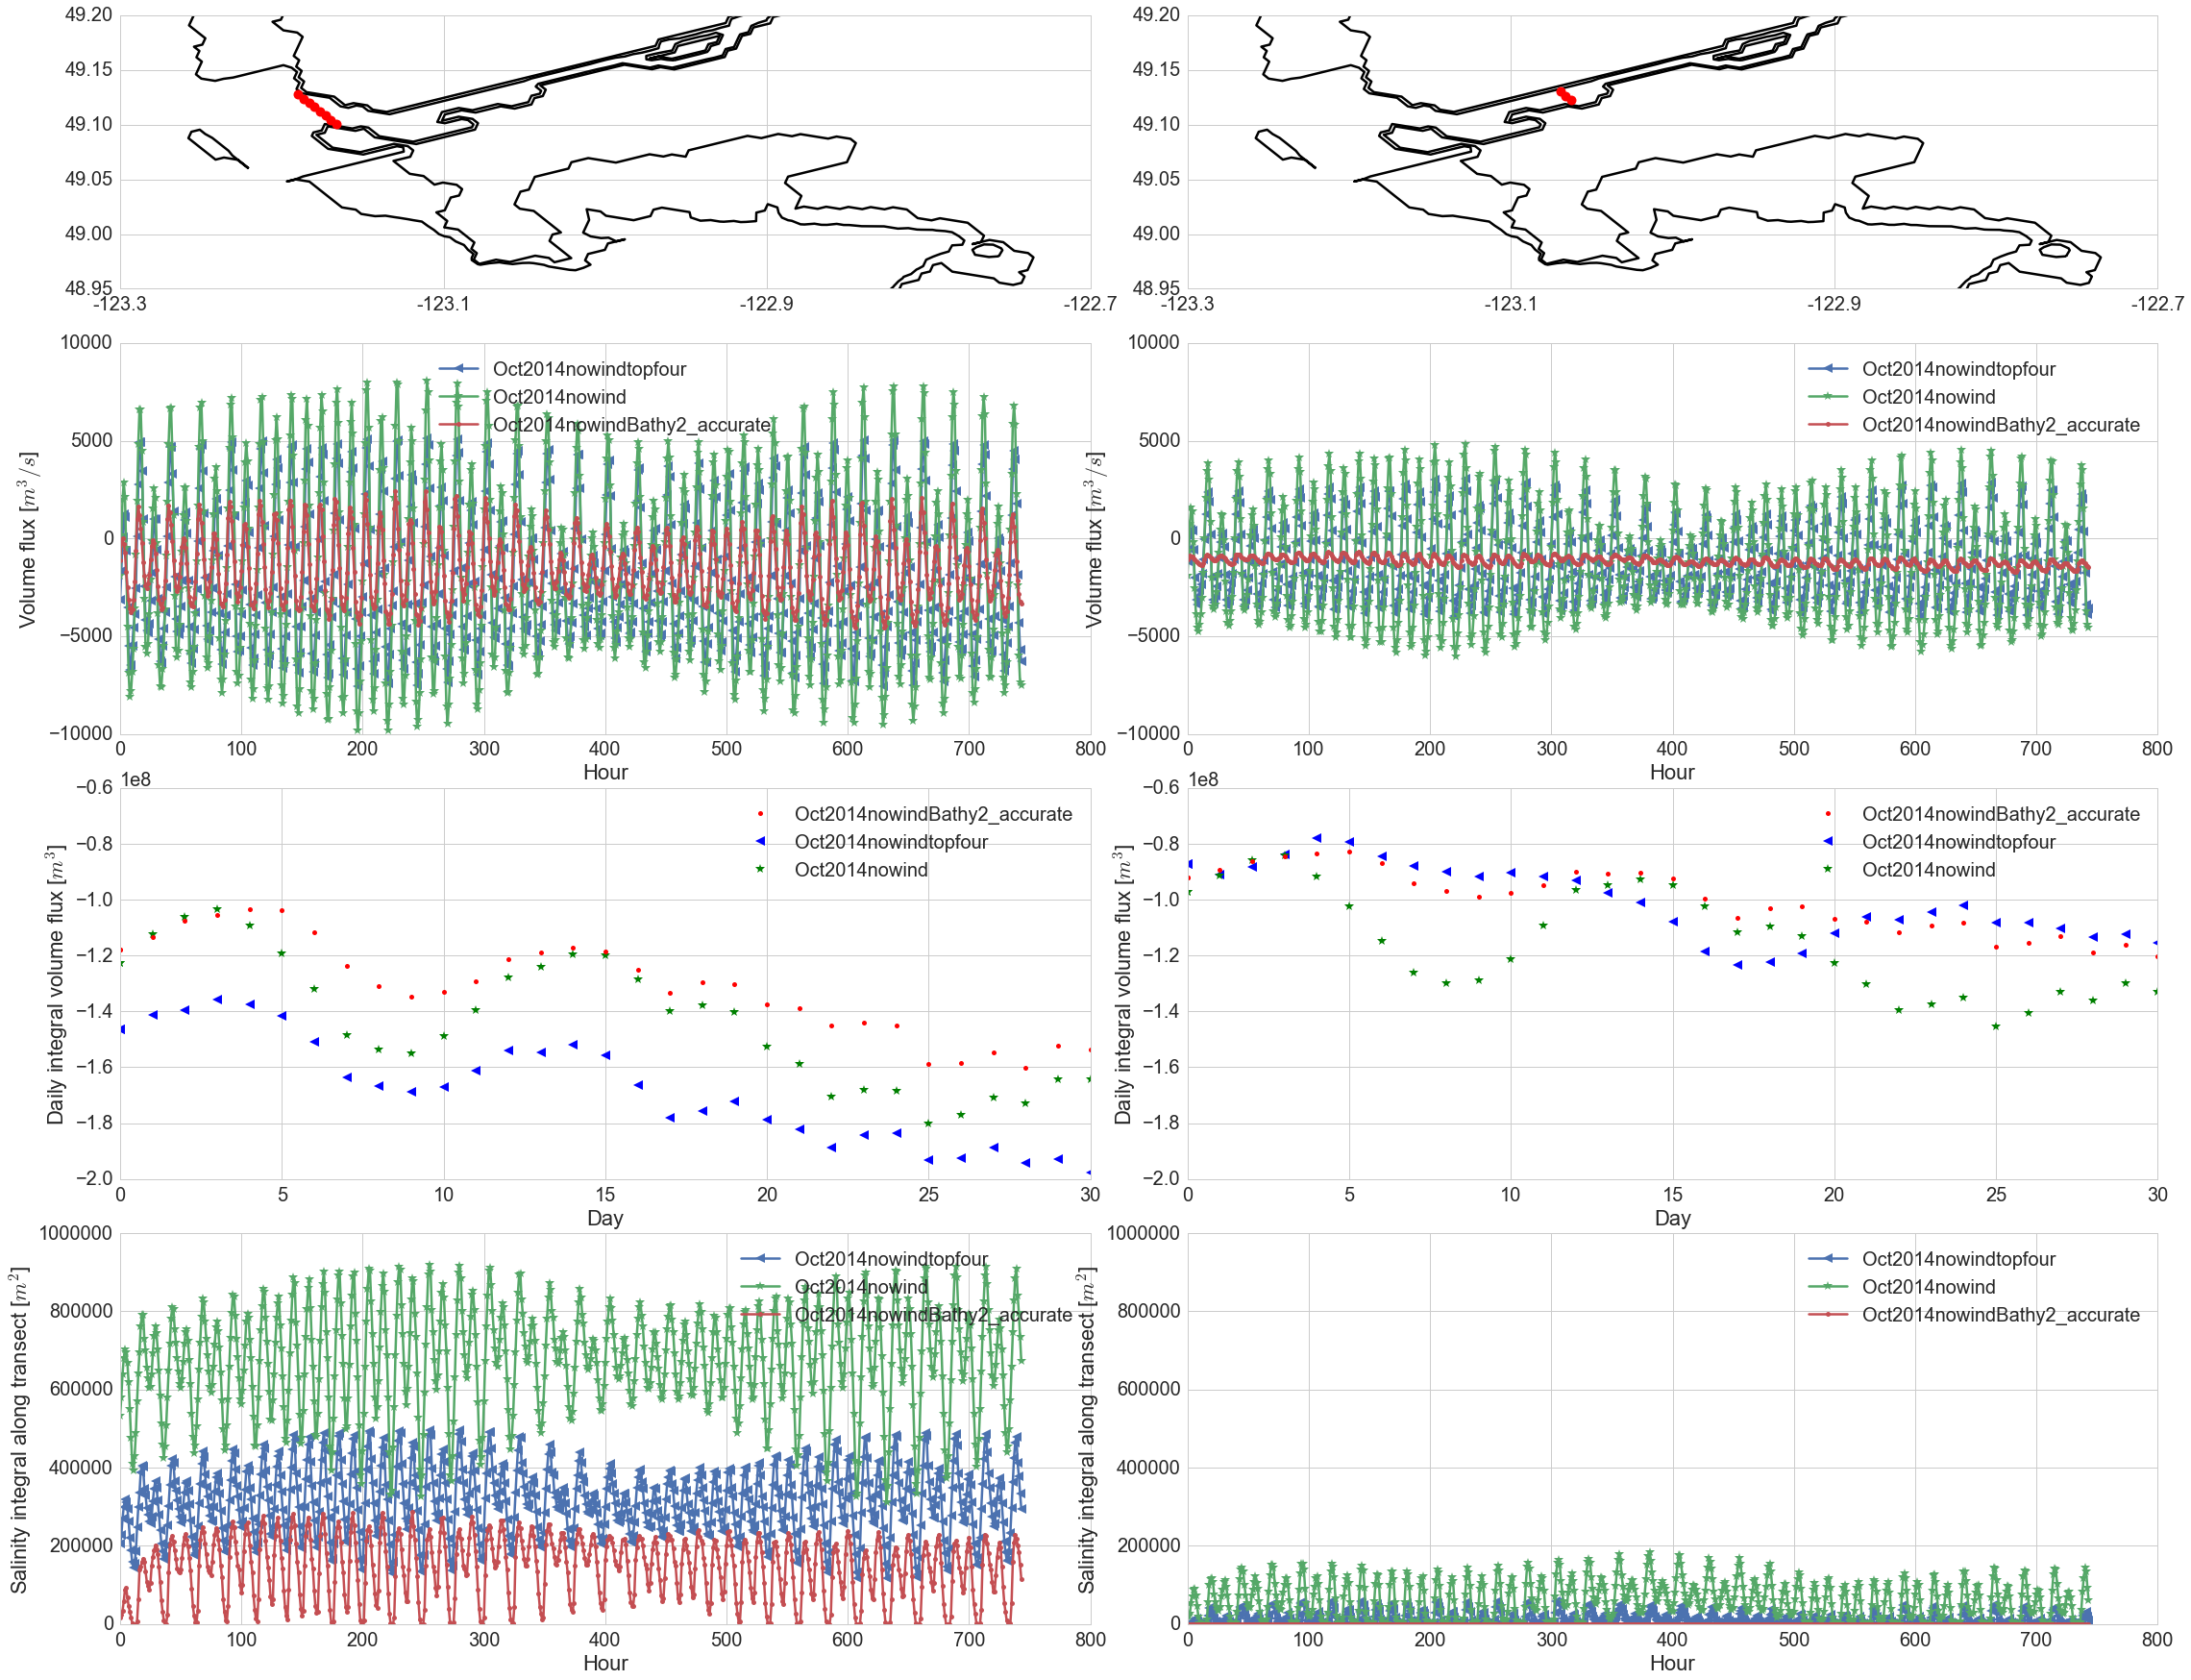

In [93]:
tst = 0;ten=743;
fig = plt.figure(figsize=(38,30))
gs = gridspec.GridSpec(4, 2,width_ratios=[1, 1], height_ratios=[0.7,1,1,1])  
gs.update(hspace=0.15, wspace=0.1) 
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])
ax4 = fig.add_subplot(gs[2,0])
ax5 = fig.add_subplot(gs[2,1])
ax6 = fig.add_subplot(gs[3,0])
ax7 = fig.add_subplot(gs[3,1])
for ax, tran in zip([ax0,ax1],['4','8']):
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5)
    ax.plot(X[transects[tran]['jst']:transects[tran]['jen'],transects[tran]['ist']],
            Y[transects[tran]['jst']:transects[tran]['jen'],transects[tran]['ist']],'ro',markersize  = 10)
    ax.set_xlim([-123.3,-122.7])
    ax.set_xticks([-123.3,-123.1,-122.9,-122.7])
    ax.set_xticklabels([-123.3,-123.1,-122.9,-122.7])
    ax.set_ylim([48.95,49.2])
for ax,axx, tran in zip([ax2,ax3],[ax4,ax5],['4','8']): ## volume flux
    trans,trans_surf,trans_to = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,30,fresh_flag = 'None')
    trans_topFour = {}; trans_all_2 = {};trans_all_6 = {}
    inte_trans_top4 = {};inte_trans_2 = {}; inte_trans_6 = {}
    
    for pa in paths:
        if pa == 'Oct2014nowindBathy2_accurate':
            inte_trans_2[pa] = np.zeros((ten+1)/24)
            trans_all_2[pa] = np.nansum(np.nansum(trans[pa][tst:ten+1],axis = 1),axis = 1)
            ax.plot(trans_all_2[pa],'-',marker = '.',label = pa,markersize = 10)
            for i in np.arange(tst,ten+1,24):
                inte_trans_2[pa][i/24] = np.sum(trans_all_2[pa][i:i+24])*3600
            axx.plot(inte_trans_2[pa],'.',color = 'r',markersize = 10)
        elif pa == 'Oct2014nowind':
            inte_trans_6[pa] = np.zeros((ten+1)/24)
            inte_trans_top4[pa] = np.zeros((ten+1)/24)
            trans_topFour[pa] = np.nansum(np.nansum(trans[pa][tst:ten+1,0:5],axis = 1),axis = 1)
            trans_all_6[pa] = np.nansum(np.nansum(trans[pa][tst:ten+1],axis = 1),axis = 1)
            ax.plot(trans_topFour[pa],'-',marker = '<',label = pa+'topfour',markersize = 10)    
            ax.plot(trans_all_6[pa],'-',marker = '*',label = pa,markersize = 10)
            for i in np.arange(tst,ten+1,24):
                inte_trans_6[pa][i/24] = np.sum(trans_all_6[pa][i:i+24])*3600
                inte_trans_top4[pa][i/24] = np.sum(trans_topFour[pa][i:i+24])*3600
            axx.plot(inte_trans_top4[pa],'<',color = 'b',markersize = 10)
            axx.plot(inte_trans_6[pa],'*',color = 'g',markersize = 10)
        ax.legend(loc = 'best')
        ax.set_xlabel('Hour')
        ax.set_ylabel('Volume flux [$m^3/s$]')
        ax.set_ylim([-1e4,1e4])
    axx.plot(inte_trans_2['Oct2014nowindBathy2_accurate'][0],'.',color = 'r',markersize = 10,label = paths[1])
    axx.plot(inte_trans_top4['Oct2014nowind'][0],'<',color= 'b',markersize = 10,label ='Oct2014nowindtopfour' )
    axx.plot(inte_trans_6['Oct2014nowind'][0],'*',color='g',markersize = 10,label = 'Oct2014nowind')
    axx.legend(loc = 'best')
    axx.set_xlabel('Day')
    axx.set_ylabel('Daily integral volume flux [$m^3$]')
    axx.set_ylim([-2e8,-0.6e8])
            
for ax, tran in zip([ax6,ax7],['4','8']): ## salinity
    trans,trans_surf,trans_to = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,30,fresh_flag = 'saltNoV')
    trans_topFour = {}; trans_all_2 = {};trans_all_6 = {}
    for pa in paths:
        if pa == 'Oct2014nowindBathy2_accurate':
            trans_all_2[pa] = np.nansum(np.nansum(trans[pa][tst:ten+1],axis = 1),axis = 1)
            ax.plot(trans_all_2[pa],'-',marker = '.',label = pa,markersize = 10)
        else:
            trans_topFour[pa] = np.nansum(np.nansum(trans[pa][tst:ten+1,0:5],axis = 1),axis = 1)
            trans_all_6[pa] = np.nansum(np.nansum(trans[pa][tst:ten+1],axis = 1),axis = 1)
            ax.plot(trans_topFour[pa],'-',marker = '<',label = pa+'topfour',markersize = 10)
            ax.plot(trans_all_6[pa],'-',marker = '*',label = pa,markersize = 10)
        ax.legend(loc = 'best')
    ax.set_ylim([0,1e6])
    ax.set_xlabel('Hour')
    ax.set_ylabel('Salinity integral along transect [$m^2$]')